In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
from one.api import ONE
one = ONE(mode='remote')

In [131]:
# Find all sessions with wheel position data using one.search
sess = list(one.search(project='brainwide', task_protocol='ephys', datasets='_ibl_wheel.position.npy'))
print(len(sess))
eid = sess[480]

485


In [132]:
# one.get_details(eid)
# one.list_datasets(eid=eid, query_type='remote')

In [133]:
# load an aggregate (group)
subject = 'SWC_043'
subject_trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')

In [134]:
# import session loader
from brainbox.io.one import SessionLoader

In [135]:
# instantiate session loader
sl = SessionLoader(one=one, eid=eid)

In [136]:
# Load in trials data
sl.load_trials()

In [137]:
df = sl.trials

In [138]:
df.columns

Index(['stimOff_times', 'goCueTrigger_times', 'contrastLeft', 'feedbackType',
       'goCue_times', 'rewardVolume', 'feedback_times', 'firstMovement_times',
       'choice', 'contrastRight', 'stimOn_times', 'response_times',
       'probabilityLeft', 'intervals_0', 'intervals_1'],
      dtype='object')

In [139]:
df[['contrastLeft', 'contrastRight', 'choice', 'feedbackType']].head()
df[['goCue_times', 'stimOn_times', 'response_times', 'feedback_times']].head()

,goCue_times,stimOn_times,response_times,feedback_times
0,263.147867,263.146933,298.976548,298.976567
1,301.853700,301.852800,302.264579,302.264600
2,307.564367,307.563233,307.832244,307.832233
3,313.381000,313.379867,313.691905,313.692667
4,317.320333,317.319400,317.784543,317.785300


In [140]:
np.sort(df['contrastLeft'].unique())

array([0.    , 0.0625, 0.125 , 0.25  , 1.    ,    nan])

In [141]:
prob_left = df['probabilityLeft']

Text(0, 0.5, 'probability')

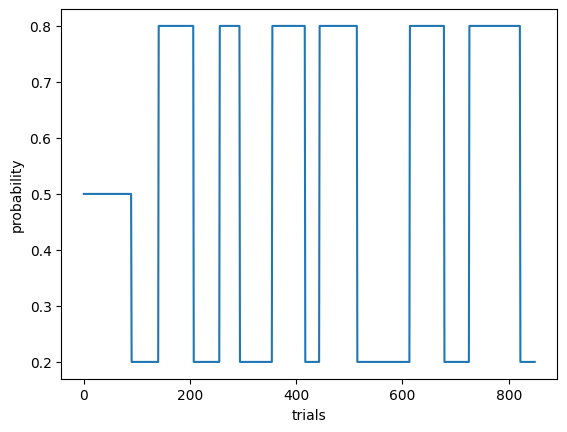

In [142]:
plt.plot(prob_left)
plt.xlabel('trials')
plt.ylabel('probability')

In [143]:
sl.load_wheel()

In [144]:
wheel_df = sl.wheel
wheel_df

,times,position,velocity,acceleration
0,1.597700,0.001534,0.000000,0.000000
1,1.598700,0.001517,-0.018902,-18.902266
2,1.599700,0.001499,-0.018869,0.032826
3,1.600700,0.001482,-0.018820,0.049762
4,1.601700,0.001464,-0.018755,0.064603
...,...,...,...,...
4647171,4648.768555,698.133057,0.000540,-0.092102
4647172,4648.769531,698.133057,0.000458,-0.082681
4647173,4648.770508,698.133057,0.000384,-0.073577
4647174,4648.771484,698.133057,0.000319,-0.064877


Average reaction time for stimulus on
Left: 0.6317719374101046
Right: 0.7673141311225427

Average reaction time on Left overall: 0.6318

Average reaction time on Right overall: 0.7673


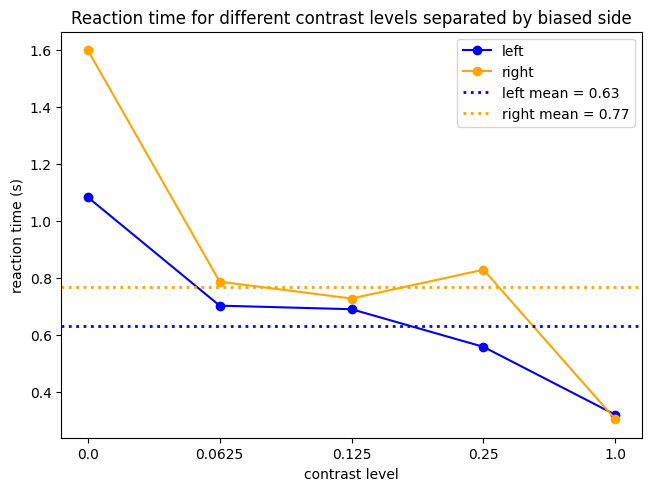

In [145]:
# Finding the reaction time
# Load in trials data
trials = one.load_object(eid, 'trials')

# Convert the trials dict to a pandas dataframe
trials_df = trials.to_df()

# Define reaction time as the time when the visual stimulus first appears and first movement time
reaction_time = trials['firstMovement_times'] - trials['stimOn_times']

# Evaluate reaction time across different trial types
# Compare reaction time for left vs right trials
left_trial_idx = ~np.isnan(trials['contrastLeft'])
right_trial_idx = ~np.isnan(trials['contrastRight'])
left_reaction_time = np.nanmean(reaction_time[left_trial_idx])
right_reaction_time = np.nanmean(reaction_time[right_trial_idx])
print(f'Average reaction time for stimulus on')
print(f'Left: {left_reaction_time}')
print(f'Right: {right_reaction_time}')

# check that the length of nan contrastLeft columns is the same as nonnan contrastRight columns
tot = trials_df.shape[0]
# print(np.sum(left_trial_idx)== tot-np.sum(right_trial_idx))

# compare reaction time for the magnitude of contrast for left and right separately
contrast_levels = np.sort(trials_df['contrastRight'].unique())
contrast_levels = contrast_levels[:5]
# contrast_levels = [0, 0.0625, 0.125, 0.25, 1]

# reaction time for each contrast level on the left
print(f'\nAverage reaction time on Left overall: {left_reaction_time:.4f}')
contrast_left_reaction_times = []
for i in range(len(contrast_levels)):
    contrast = contrast_levels[i]
    trial_idx = trials_df[trials_df['contrastLeft']==contrast].index
    left_reaction = np.nanmean(reaction_time[trial_idx])
    contrast_left_reaction_times.append(left_reaction)
    # print(f'Average reaction time for contrast level {contrast_levels[i]} is {left_reaction:.4f}.')

# reaction time for each contrast level on the right
contrast_right_reaction_times = []
print(f'\nAverage reaction time on Right overall: {right_reaction_time:.4f}')
for i in range(len(contrast_levels)):
    contrast = contrast_levels[i]
    trial_idx = trials_df[trials_df['contrastRight']==contrast].index
    right_reaction = np.nanmean(reaction_time[trial_idx])
    contrast_right_reaction_times.append(right_reaction)
    # print(f'Average reaction time for contrast level {contrast_levels[i]} is {right_reaction:.4f}.')

# plot the reaction time across contrast levels on left and right
fig, ax = plt.subplots(layout='constrained')
ax.plot(range(len(contrast_levels)), contrast_left_reaction_times, label='left', marker='o', color='blue')  # plot as if 0, 1, 2... are the x axis values
ax.plot(range(len(contrast_levels)), contrast_right_reaction_times, label='right', marker='o', color='orange')
plt.xticks(range(len(contrast_levels)), contrast_levels) # but label them with the contrast levels as if categorical
ax.set_xlabel('contrast level')
ax.set_ylabel('reaction time (s)')
ax.set_title('Reaction time for different contrast levels separated by biased side')
plt.axhline(y=left_reaction_time, color='blue', linestyle=':', linewidth=2, label=f'left mean = {left_reaction_time:.2f}')
plt.axhline(y=right_reaction_time, color='orange', linestyle=':', linewidth=2, label=f'right mean = {right_reaction_time:.2f}')
plt.legend()
plt.show()


In [146]:
# Compare reaction time for correct vs incorrect trials
correct_trial_idx = trials_df['feedbackType'] == 1
incorrect_trial_idx = trials_df['feedbackType'] == -1
correct_reaction_time = np.nanmean(reaction_time[correct_trial_idx])
incorrect_reaction_time = np.nanmean(reaction_time[incorrect_trial_idx])
print(f'\nAverage reaction time for trials that were')
print(f'Correct: {correct_reaction_time}')
print(f'Incorrect: {incorrect_reaction_time}')


Average reaction time for trials that were
Correct: 0.6095257215597006
Incorrect: 1.4420450755543721


### Class with functions for calculating reaction time across a session

In [147]:
class ReactionTime:
    """
    Computes the reaction times for any session. 

    Constructor params:
    reaction_type: defines the way to compute reaction time as either the difference between stimulus onset and first movement time (0)
    or the difference between stimulus onset and response time (1). 
    
    eid: the eid of the session. 
    
    Methods: 
    avg_reaction_time(self): computes and returns the average reaction time for all trials, and separated by left and right trials. 

    reaction_time_with_contrast(self, contrast_level, side=None): computes and returns the average reaction time for the specified 
    contrast level, where the contrast level must be a value in [0, 0.0625, 0.125, 0.25, 1]. 

    reaction_time_with_reward(self, reward): computes and returns the reaction time by the specified type of reward (rewarded or not). 
    Pass in reward=1 for rewarded trials and reward=0 for non-rewarded trials.


    """
    def __init__(self, reaction_type, eid):
        self.eid = eid  # Instance variable
        
        # load trial data
        trials = one.load_object(eid, 'trials')
        trials_df = trials.to_df()
        self.trials = trials_df  # make only the df accessible
        
        if reaction_type == 0:
            self.reaction_time = self.trials['firstMovement_times'] - self.trials['stimOn_times']
        elif reaction_type == 1:
            self.reaction_time = self.trials['firstMovement_times'] - self.trials['stimOn_times']
        else: 
            ValueError("reaction_type must be a value 0 or 1.")

    def avg_reaction_time(self):
        avg_reaction_time = np.nanmean(reaction_time)
        left_trial_idx = ~np.isnan(self.trials['contrastLeft'])
        right_trial_idx = ~np.isnan(self.trials['contrastRight'])
        left_reaction_time = np.nanmean(reaction_time[left_trial_idx])
        right_reaction_time = np.nanmean(reaction_time[right_trial_idx])
        print(f'Average reaction time for all trials: {avg_reaction_time:.4f}')
        print(f'Average reaction time for stimulus on')
        print(f'Left: {left_reaction_time}')
        print(f'Right: {right_reaction_time}')

    def reaction_time_with_contrast(self, contrast_level, side=None):
        contrast_levels = [0, 0.0625, 0.125, 0.25, 1]
        assert contrast_level in contrast_levels
        if side!= None:
            assert side in ['left', 'right']
            if side == 'left':
                trial_idx = self.trials[(self.trials['contrastLeft']==contrast)].index
                result = np.nanmean(reaction_time[trial_idx])
                print(f'\nAverage reaction time on {side} side for contrast level {contrast_level} is {result:.4f}.')
            else: 
                trial_idx = self.trials[(self.trials['contrastRight']==contrast)].index
                result = np.nanmean(reaction_time[trial_idx])
                print(f'\nAverage reaction time on {side} side for contrast level {contrast_level} is {result:.4f}.')
        else:
            trial_idx = self.trials[(self.trials['contrastLeft']==contrast) | (self.trials['contrastRight']==contrast)].index
            result = np.nanmean(reaction_time[trial_idx])
            print(f'\nAverage reaction time for contrast level {contrast_level} is {result:.4f}.')
    
    def reaction_time_with_reward(self, reward):
        assert reward in [1, 0]
        if reward==1: 
            correct_trial_idx = self.trials['feedbackType'] == 1
            correct_reaction_time = np.nanmean(reaction_time[correct_trial_idx])
            print(f'\nAverage reaction time for trials that were correct: {correct_reaction_time:.4f}')
        else: 
            incorrect_trial_idx = trials_df['feedbackType'] == -1
            incorrect_reaction_time = np.nanmean(reaction_time[incorrect_trial_idx])
            print(f'\nAverage reaction time for trials that were incorrect: {incorrect_reaction_time:.4f}')

In [148]:
rt = ReactionTime(reaction_type = 1, eid=eid)
rt.avg_reaction_time()
rt.reaction_time_with_contrast(contrast_level=1, side='right')
rt.reaction_time_with_reward(reward=1)

Average reaction time for all trials: 0.6957
Average reaction time for stimulus on
Left: 0.6317719374101046
Right: 0.7673141311225427

Average reaction time on right side for contrast level 1 is 0.3025.

Average reaction time for trials that were correct: 0.6095


Text(0, 0.5, 'Reaction time (s)')

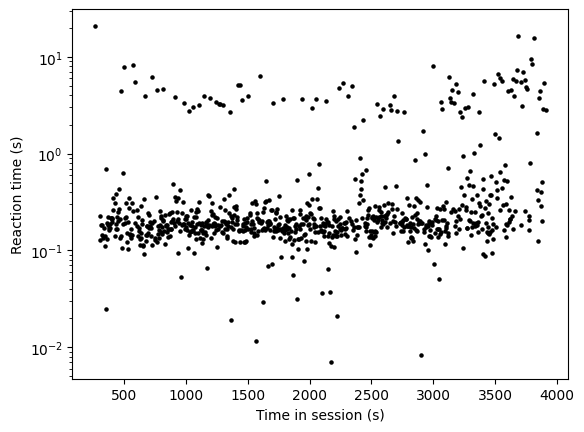

In [149]:
# 5. Make plot of reaction time across session
fig, ax = plt.subplots()
ax.scatter(trials['stimOn_times'], reaction_time, c='k', s=5)
ax.set_yscale("log")  # set y axis to log scale
ax.set_xlabel('Time in session (s)')
ax.set_ylabel('Reaction time (s)')

### PSTH for wheel movement around stimOn times

In [194]:
# PSTH for wheel velocity around stimOn times, comparison left and right sides. 

# Find times when first move is detected
events = np.array(sl.trials['stimOn_times'])

from brainbox.singlecell import bin_spikes
# Compute raster of wheel in 0.05s bins between 0.5s before the first move is detected to 1s after the first move is detected
bin_size = 0.05
pre_time = 0.2
post_time = 1
wheel_raster, times = bin_spikes(sl.wheel['times'], events, pre_time=pre_time, post_time=post_time, 
                                 bin_size=bin_size, weights=sl.wheel['velocity'])
# events

# separate by left and right trials
left_idx = ~np.isnan(sl.trials['contrastLeft'])
right_idx = ~np.isnan(sl.trials['contrastRight'])
wheel_psth_left = np.nanmean(wheel_raster[left_idx], axis=0)
wheel_psth_right = np.nanmean(wheel_raster[right_idx], axis=0)

# for all trials, not separated by left or right
psth_avg = np.mean(wheel_raster, axis=0) 

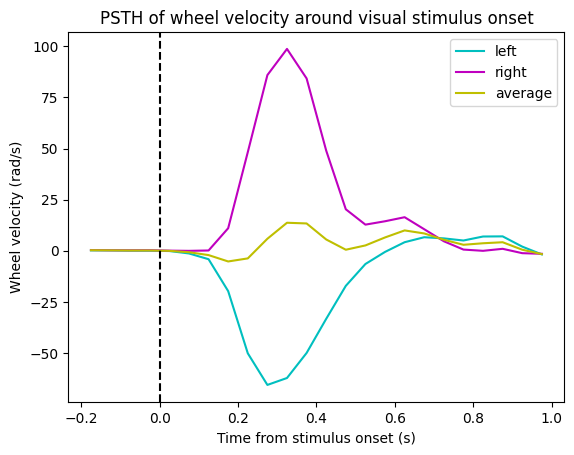

In [195]:
# Plot the psths
fig, axs = plt.subplots(gridspec_kw={'wspace': 0.5})
axs.plot(times, wheel_psth_left, c='c')
axs.plot(times, wheel_psth_right, c='m')
axs.plot(times, psth_avg, c='y', label='average')
axs.legend(['left', 'right', 'average'], )
axs.axvline(0, c='k', linestyle='--')
axs.set_xlabel('Time from stimulus onset (s)')
axs.set_ylabel('Wheel velocity (rad/s)')
plt.title('PSTH of wheel velocity around visual stimulus onset')
plt.show()

In [196]:
# compare PSTH across contrast levels for just left side
left_trials = trials_df[left_trial_idx]

psth_dict = {}

for level in contrast_levels:
    idx = np.where(left_trials['contrastLeft'] == level)[0]  # trials for this difficulty
    if len(idx) == 0:
        continue  # skip if no trials of this level

    bin_size = 0.025
    pre_time = 0.25
    post_time = 0.75

    wheel_raster, tscale = bin_spikes(
        sl.wheel['times'],
        events[idx],  # only trials for this difficulty
        pre_time=pre_time,
        post_time=post_time,
        bin_size=bin_size,
        weights=sl.wheel['velocity']  
    )

    psth = (wheel_raster.mean(axis=0), np.std(wheel_raster, axis=0) / np.sqrt(wheel_raster.shape[0]))
    psth_dict[level] = psth  # store for this level

# formatted for printing
np.set_printoptions(legacy='1.25')
psth_dict

# compute the standard error, which is defined as the stdev/sqrt(N)
# psth_stdev = np.std(wheel_raster, axis=0)
# psth_ste = psth_stdev / np.sqrt(wheel_raster.shape[0])
# psth_ste


{0.0: (array([ 0.18388639,  0.11942747,  0.07493592,  0.12584331,  0.14765201,
          0.12544484,  0.12855137,  0.10652155,  0.10682872,  0.09274178,
         -0.1270525 , -0.67112917, -1.24455518, -1.58660378, -1.86318417,
         -2.19000649, -2.31728242, -3.04465214, -5.11578387, -4.64644622,
         -0.61648528,  5.99499462, 12.18949923, 15.94044623, 16.81228837,
         13.72865046,  7.20811494,  0.29679256, -4.74089582, -8.84138173,
         -9.91860679, -6.39054837, -0.56530935,  4.90136485,  6.96791392,
          7.09191787,  4.77772394, -0.08512708, -4.17239813, -5.48777991]),
  array([0.08648599, 0.04881963, 0.08080398, 0.06010994, 0.04325555,
         0.06311312, 0.0450996 , 0.06396643, 0.06600225, 0.08594088,
         0.23610993, 0.694235  , 1.14864072, 1.33804814, 1.48331816,
         1.85584818, 2.57498471, 3.70560917, 5.59763818, 7.34868486,
         8.60084406, 9.08652005, 9.12330268, 8.89632035, 8.31680733,
         7.88374778, 7.84707458, 7.66920997, 7.09173626,

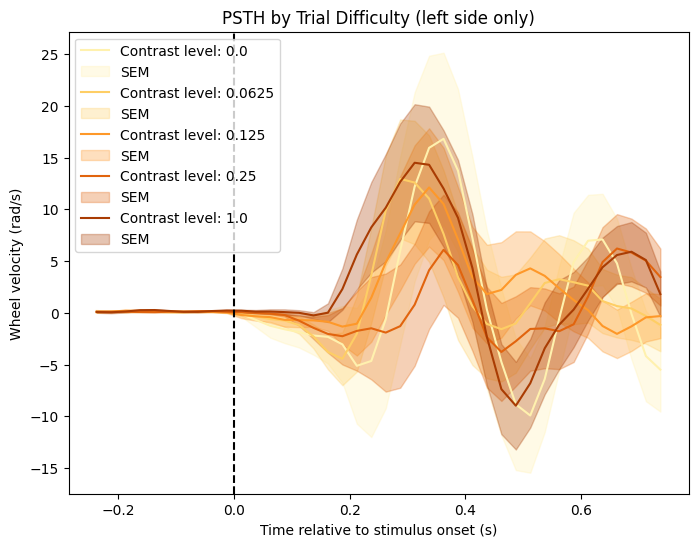

In [197]:
import seaborn as sns

plt.figure(figsize=(8, 6))
n_lines = len(psth_dict)

# Get discrete colors from the 'Blues' palette
palette = sns.color_palette("YlOrBr", n_lines)  # returns list of RGB tuples

idx = 0
for level, psth in psth_dict.items():
    plt.plot(tscale, psth[0], color=palette[idx], label=f'Contrast level: {level}')
    plt.fill_between(tscale, psth[0] - psth[1], psth[0] + psth[1],
                 color=palette[idx], alpha=0.3, label='SEM')
    idx += 1

plt.xlabel('Time relative to stimulus onset (s)')
plt.ylabel('Wheel velocity (rad/s)')
plt.title('PSTH by Trial Difficulty (left side only)')
plt.axvline(0, c='k', linestyle='--')
plt.legend()
plt.show()

In [198]:
# extract low contrast trials
low_contrast_trials = trials_df[(trials_df['contrastLeft']==0)|(trials_df['contrastRight']==0)]
# low_contrast_trials

In [199]:
# PSTH for different probabilities, but only for low contrast trials

probs = np.unique(low_contrast_trials['probabilityLeft'])

psth_probs = {}

for prob in probs:
    idx = np.where(low_contrast_trials['probabilityLeft'] == prob)[0]  # trials for this probability
    if len(idx) == 0:
        continue  # skip if no trials of this probability

    bin_size = 0.01
    pre_time = 0.5
    post_time = 1.25

    wheel_raster, tscale = bin_spikes(
        sl.wheel['times'],
        events[idx],  # only trials for this difficulty
        pre_time=pre_time,
        post_time=post_time,
        bin_size=bin_size,
        weights=sl.wheel['velocity']  
    )

    psth = wheel_raster.mean(axis=0)  # first dimension is trials, second dimension is time (one number for each bin)
    psth_probs[prob] = psth  # store for this level

# formatted for printing
np.set_printoptions(legacy='1.25')
# psth_probs


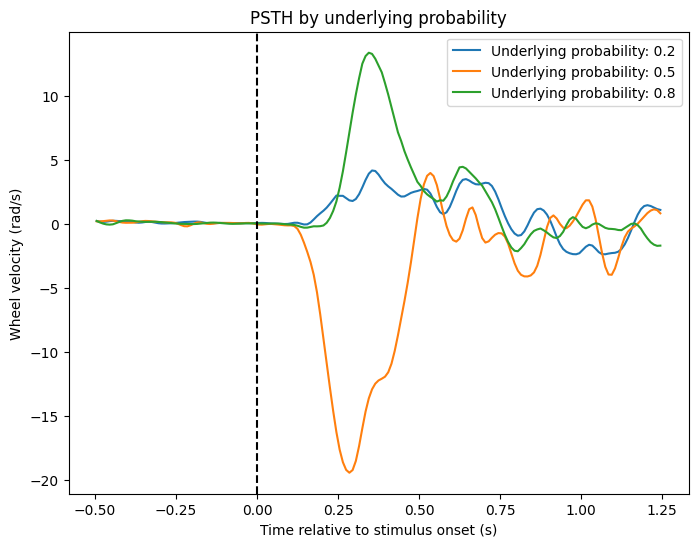

In [200]:
# plot psth
plt.figure(figsize=(8, 6))
for prob, psth in psth_probs.items():
    plt.plot(tscale, psth, label=f'Underlying probability: {prob}')

plt.xlabel('Time relative to stimulus onset (s)')
plt.ylabel('Wheel velocity (rad/s)')
plt.title('PSTH by underlying probability')
plt.axvline(0, c='k', linestyle='--')
plt.legend()
plt.show()

In [ ]:
# # function for computing the PSTH for a given session
# def get_psth(eid, events, bin_size=0.05, pre_time=0.5, post_time=1, side=None, contrast=None):

#     gcamp_df = load_photometry(eid)
#     trials_df = load_trials(eid)
    
#     # load helper package
#     from brainbox.singlecell import bin_spikes

#     # Compute raster using bin_spikes

#     times = list(gcamp_df.index) 
#     events = np.array(trials_df[events]) # e.g. 'firstMovement_times'
#     bin_size = bin_size
#     pre_time = pre_time
#     post_time = post_time
#     raster, tscale = bin_spikes(times, events, pre_time=pre_time, post_time=post_time, 
#                                     bin_size=bin_size, weights=gcamp_df.values[:,0])  
    
#     if side=='left':
#         left_idx = ~np.isnan(trials_df['contrastLeft'])
#         psth_avg = np.nanmean(raster[left_idx], axis=0)

#     elif side=='right':
#         right_idx = ~np.isnan(trials_df['contrastRight'])
#         psth_avg = np.nanmean(raster[right_idx], axis=0)
    
#     else: 
#         # average over all trials
#         psth_avg = np.mean(raster, axis=0) 
    
#     # contrast levels in a list
#     if contrast!=None: 
#         psth_contrast = {}
#         for level in contrast:
#             idx = np.where((trials_df['contrastLeft'] == level)|(trials_df['contrastRight'] == level))[0]  # trials for this difficulty
#             if len(idx) == 0:
#                 continue  # skip if no trials of this level
        
#             psth = np.nanmean(raster[idx], axis=0)
#             psth_contrast[level] = psth  # store for this level

#         return psth_avg, tscale, psth_contrast
    
#     else: 
#         return psth_avg, tscale
        

In [ ]:
# function for plotting PSTH, NEEDS FIXING

def plot_psth(eid, events, bin_size=0.05, pre_time=0.5, post_time=1, side=None, contrast=None):
    
    # set up the figure
    fig, axs = plt.subplots(1, 2, gridspec_kw={'wspace': 0.5})

    if contrast!=None: 
        psth_avg, tscale, psth_contrast = get_psth(eid, events, bin_size=bin_size, 
                                                pre_time=pre_time, post_time=post_time, 
                                                side=side, contrast=contrast)
        for level, psth in psth_contrast.items():
            axs[1].plot(tscale, psth, label=f'Contrast level: {level}')
    
    else:
        psth_avg, tscale = get_psth(eid, events, bin_size=bin_size, 
                                                pre_time=pre_time, post_time=post_time, 
                                                side=side, contrast=contrast)
        axs[0].plot(tscale, psth_avg, label = 'Average')
    
    axs[0].axvline(0, c='k', linestyle='--')
    axs[1].axvline(0, c='k', linestyle='--')
    axs[0].set_xlabel('Time relative to event (s)')
    axs[0].set_ylabel('Raster')
    plt.title('PSTH by Trial Difficulty (contrast level)')
    plt.legend()
    plt.show()  

## Photometry data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pathfile = '/Users/sarahhu/ibl_photometry/DR-5HT/'
metadf = pd.read_parquet(pathfile + 'sessions.pqt')
metadf.reset_index(inplace=True)
metadf.head()

,index,eid,subject,start_time,task_protocol,session_type,session_n,NM,target,roi
0,34,fe2a712b-014b-47e7-b2ac-f85d0571cf44,ZFM-03065,2021-08-27T10:18:12.784055,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,4,5HT,[DR],[Region1G]
1,35,ba01bf35-8a0d-4ca3-a66e-b3a540b21128,ZFM-03059,2021-08-27T11:18:32.529960,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,4,5HT,[DR],[Region1G]
2,38,f2a6559d-1e45-4e83-8f65-1295ef50ed4b,ZFM-03065,2021-08-30T08:29:50.008373,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,5,5HT,[DR],[Region1G]
3,42,c5cdd496-7400-4c0f-b326-55016bce4fcf,ZFM-03065,2021-08-31T10:23:23.726423,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,6,5HT,[DR],[Region1G]
4,49,fd22820d-a2c2-4c06-b90e-f399344e1c0a,ZFM-03059,2021-09-01T09:54:32.034120,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,7,5HT,[DR],[Region1G]


In [2]:
# filter out late-stage training data
metadf[(metadf['session_n'].between(15, 30)) & (metadf['session_type']=='training')] 
meta_train_df = metadf[metadf['session_type']=='training']
meta_train_df.groupby('subject').max('session_n') # mice who completed training faster: ZFM-03059, ZFM-03065

,index,session_n
subject,,
ZFM-03059,144,31
ZFM-03065,153,34
ZFM-05235,1569,67
ZFM-05236,1444,48
ZFM-05245,1473,51
ZFM-05248,1481,54


### Photometry class for functions of loading and plotting

In [3]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

@dataclass
class Params: 
    """
    Parameters for PSTH and photometry analysis.

    Attributes
    ----------
    pre_time : float
        Time before event to include in the analysis window (in seconds).
    post_time : float
        Time after event to include in the analysis window (in seconds).
    bin_size : float
        Size of time bins for the histogram (in seconds).
    baseline_time : float
        Time window before the event used for baseline fluorescence calculation (in seconds).
    """
    pre_time: float=4
    post_time: float=6
    bin_size: float=0.1
    baseline_time: float=0.5

class Photometry: 
    """
    Class for analyzing photometry data aligned to behavioral events.

    Parameters
    ----------
    eid : str
        Experiment ID used to load data files.

    trial_idx : list, optional
        Indices of trial numbers to select from the session. 

    """

    def __init__(self, eid, trial_idx=None):
        
        # private instances
        self.__pathfile = '/Users/sarahhu/ibl_photometry/DR-5HT/'
        self.__eid = eid
        
        if trial_idx is not None:
            self.__trials_df = self.load_trials()[self.__convert_trial_idx(trial_idx)]
        else: 
            self.__trials_df = self.load_trials()
            
        self.__gcamp_df = self.load_photometry()

        # public instances
        self.firstMovement_times = self.__trials_df['firstMovement_times']
        self.contrastRight = self.__trials_df['contrastRight']
        self.choice = self.__trials_df['choice']
        self.contrastLeft = self.__trials_df['contrastLeft']
        self.response_times = self.__trials_df['response_times']
        self.feedbackType = self.__trials_df['feedbackType']
        self.probabilityLeft = self.__trials_df['probabilityLeft']
        self.stimOn_times = self.__trials_df['stimOn_times']
        self.goCue_times = self.__trials_df['goCue_times']
        self.feedback_times = self.__trials_df['feedback_times']

    
    def __convert_trial_idx(self, trial_idx): 
        total_trial = self.load_trials().shape[0]
        if len(trial_idx) == 2:
            tid = [True if i in range(trial_idx[0], trial_idx[1]) else False for i in range(total_trial)]
        else:
            tid = trial_idx
        return tid

    # functions for loading
    def load_photometry(self):
        df = pd.read_parquet(self.__pathfile + self.__eid + '_gcamp.pqt')
        return df

    def load_trials(self): 
        df = pd.read_parquet(self.__pathfile + self.__eid + '_trials.pqt')
        return df

    def load_isosbestic(self): 
        df = pd.read_parquet(self.__pathfile + self.__eid + '_isosbestic.pqt')
        return df

    # Modified based on bin_spikes from brainbox.singlecell 
    def __bin_photometry(self, align_times, params: Params):
        """
        Internal method to compute trial-aligned, binned photometry signal (ΔF/F).
        Each trial is aligned to the specified event, and its fluorescence trace is:
        1. Binned over time relative to the event.
        2. Normalized by its own baseline fluorescence to compute ΔF/F.
        3. Returned as a matrix of shape (n_trials, n_bins).
        """

        # align_times = np.array(self.__trials_df[align_times])
       
        signal = self.__gcamp_df.values[:,0]
        times = list(self.__gcamp_df.index) 
        
        n_bins_pre = int(np.ceil(params.pre_time / params.bin_size))
        n_bins_post = int(np.ceil(params.post_time / params.bin_size))
        n_bins = n_bins_pre + n_bins_post
        tscale = np.arange(-n_bins_pre, n_bins_post + 1) * params.bin_size
        ts = np.repeat(align_times[:, np.newaxis], tscale.size, axis=1) + tscale
        epoch_idxs = np.searchsorted(times, np.c_[ts[:, 0], ts[:, -1]])
        bins = np.zeros(shape=(align_times.shape[0], n_bins))

        for i, (ep, t) in enumerate(zip(epoch_idxs, ts)):

            # Determine baseline period indices
            baseline_start = align_times[i] - params.baseline_time
            baseline_end = align_times[i]  # up to event onset
            baseline_idx = np.searchsorted(times, [baseline_start, baseline_end])

            # Compute baseline fluorescence (mean during baseline window)
            if baseline_idx[0] < baseline_idx[1]:  # ensure valid window
                F_baseline = np.mean(signal[baseline_idx[0]:baseline_idx[1]])
            else:
                F_baseline = np.nan  # if no points in baseline window
            
            # also account for underlying (longer-term) fluctuations one second prior to events
            fluctuation_time = align_times[i] - 3  # 1s window hard-coded!
            fluctuation_idx = np.searchsorted(times, [fluctuation_time, align_times[i]])
            fluctuation_signal = signal[fluctuation_idx[0]:fluctuation_idx[1]]
            if len(fluctuation_signal) > 0:
                fluc_std = np.nanstd(fluctuation_signal, axis=0)
            else:
                fluc_std = np.nan

            # Compute fluorescence during trial window
            trial_signal = signal[ep[0]:ep[1]]
            xind = (np.floor((times[ep[0]:ep[1]] - t[0]) / params.bin_size)).astype(np.int64)
            
            r_counts = np.bincount(xind, minlength=tscale.shape[0])
            r_sum = np.bincount(xind, minlength=tscale.shape[0], weights=trial_signal)

            # avoid division by zero
            with np.errstate(divide='ignore', invalid='ignore'):
                r_mean = np.true_divide(r_sum, r_counts)
                r_mean[r_counts == 0] = np.nan  # if no data points in bin, set to NaN

            binned_signal = r_mean[:-1]  # remove the last bin 

            # Compute dF/F for this trial
            
            # fluc_std = 1 # placeholder

            if not np.isnan(F_baseline) and F_baseline != 0 and not np.isnan(fluc_std) and fluc_std != 0:
                bins[i, :] = (binned_signal - F_baseline) / F_baseline / fluc_std 
            else:
                bins[i, :] = np.nan  # skip if baseline invalid or zero

        tscale = (tscale[:-1] + tscale[1:]) / 2

        return bins, tscale
    
    def __get_filtered_trials_df(self, side=None, feedback_type=None, bias=None):
        
        # Start with full mask (all True)
        mask = np.ones(len(self.__trials_df), dtype=bool)

        # Apply side filter
        if side == 'left':
            mask &= ~np.isnan(self.__trials_df['contrastLeft'])
        elif side == 'right':
            mask &= ~np.isnan(self.__trials_df['contrastRight'])

        # Apply feedback_type filter
        if feedback_type == 1.0:
            mask &= self.__trials_df['feedbackType'] == 1.0
        elif feedback_type == -1.0:
            mask &= self.__trials_df['feedbackType'] == -1.0
        elif feedback_type is not None:
            raise Exception("feedback_type must be -1.0 (incorrect) or 1.0 (correct)")

        # Apply bias filter
        if bias == 0:
            mask &= self.__trials_df['probabilityLeft'] == 0.5
        elif bias == 1:
            mask &= (self.__trials_df['probabilityLeft'] == 0.2) | (self.__trials_df['probabilityLeft'] == 0.8)
        elif bias is not None:
            raise Exception("bias must be 0 (no bias) or 1 (biased)")
        
        return mask

    
    def get_psth(self, events, params: Params, side=None, contrast=None, feedback_type=None, bias=None):
        """
        Compute PSTH aligned to a specific event with optional filtering by the side, contrast level, 
        feedback type, and bias in experimental setup. 

        Params
        -------
        events : str
            Column name of the event times to align to.
        params : Params
            Analysis parameters.
        side : str, optional
            'left' or 'right' trials.
        contrast : list, optional
            List of contrast levels to include.
        feedback_type : float, optional
            correct trials (1.0) or incorrect trials (-1.0).
        bias: int, optional
            50-50 trials (0) or 20-80 trials (1). 

        Returns
        -------
        psth_avg : np.ndarray of shape (n_bins,)
            The average binned ΔF/F (%) signal across all selected trials.
            Each trial is first normalized to its own baseline before averaging.
            
        tscale : np.ndarray of shape (n_bins,)
            The time points (in seconds) corresponding to the center of each bin.
            
        psth_contrast : dict of {float: np.ndarray of shape (n_bins,)}
            Dictionary mapping each contrast level to the average binned dF/F (%) signal 
            across all trials for that specific contrast level.
        """

        events = np.array(self.__trials_df[events])  # e.g. 'firstMovement_times'
        dF_F, tscale = self.__bin_photometry(events, params)  
       
        # print(f'dF_F shape: {dF_F.shape}')
        # print(f'tscale shape: {tscale.shape}')
        # print(f'trials_df shape {self.__trials_df.shape}')
        # print(f'gcamp_df shape {self.__gcamp_df.shape}')

        if side is not None: 
            left_idx = ~np.isnan(self.contrastLeft)
            self.__left_psth = np.nanmean(dF_F[left_idx], axis=0)
            self.__left_psth_sem = stats.sem(dF_F[left_idx], axis=0, nan_policy='omit')
            right_idx = ~np.isnan(self.contrastRight)
            self.__right_psth = np.nanmean(dF_F[right_idx], axis=0)
            self.__right_psth_sem = stats.sem(dF_F[right_idx], axis=0, nan_policy='omit')
        
        if feedback_type is not None: 
            correct_idx = self.feedbackType == 1.0
            self.__correct_psth = np.nanmean(dF_F[correct_idx], axis=0)
            self.__correct_psth_sem = stats.sem(dF_F[correct_idx], axis=0, nan_policy='omit')
            incorrect_idx = self.feedbackType == -1.0
            self.__incorrect_psth = np.nanmean(dF_F[incorrect_idx], axis=0)
            self.__incorrect_psth_sem = stats.sem(dF_F[incorrect_idx], axis=0, nan_policy='omit')

        if bias is not None: 
            no_bias_idx = self.probabilityLeft == 0.5
            self.__no_bias_psth = np.nanmean(dF_F[no_bias_idx], axis=0)
            self.__no_bias_psth_sem = stats.sem(dF_F[no_bias_idx], axis=0, nan_policy='omit')

            # skip if no bias trials
            if (0.8 in self.probabilityLeft.unique()) | (0.2 in self.probabilityLeft.unique()):
                bias_idx = (self.probabilityLeft == 0.2) | (self.probabilityLeft == 0.8)
                self.__bias_psth = np.nanmean(dF_F[bias_idx], axis=0)
                self.__bias_psth_sem = stats.sem(dF_F[bias_idx], axis=0, nan_policy='omit')

        # filter data
        mask = self.__get_filtered_trials_df(side=side, feedback_type=feedback_type, bias=bias)
        trials = dF_F[mask]
        trials_data = self.__trials_df[mask]

        # take the average over all identified trials
        psth_avg = np.nanmean(trials, axis=0) 
        # self._psth_sem = np.nanstd(trials, axis=0) / np.sqrt(trials.shape[0]) 
        self._psth_sem = stats.sem(trials, axis=0, nan_policy='omit')
        
        # store psth for different contrast levels
        psth_contrast = {}
        self._psth_contrast_sem = {}
        
        if contrast is not None:

            contrast.sort()

            for level in contrast:
                # trial indices for this difficulty
                idx = np.where((trials_data['contrastLeft'] == level)|(trials_data['contrastRight'] == level))[0] 
                if len(idx) == 0:
                    continue  # skip if no trials of this level
        
                psth_contrast[level] = np.nanmean(trials[idx], axis=0) # store for this level
                # self._psth_contrast_sem[level] = np.nanstd(trials[idx], axis=0) / np.sqrt(trials[idx].shape[0])
                self._psth_contrast_sem[level] = stats.sem(trials[idx], axis=0, nan_policy='omit')
            
            return psth_avg, tscale, psth_contrast
        
        else:
            return psth_avg, tscale

    def fluctuations(self, align_times, params: Params):
        
        align_times = np.array(self.__trials_df[align_times])
        signal = self.__gcamp_df.values[:,0]
        times = list(self.__gcamp_df.index) 
        
        n_bins_pre = int(np.ceil(params.pre_time / params.bin_size))
        n_bins_post = int(np.ceil(params.post_time / params.bin_size))
        n_bins = n_bins_pre + n_bins_post
        tscale = np.arange(-n_bins_pre, n_bins_post + 1) * params.bin_size
        ts = np.repeat(align_times[:, np.newaxis], tscale.size, axis=1) + tscale
        epoch_idxs = np.searchsorted(times, np.c_[ts[:, 0], ts[:, -1]])
        bins = np.zeros(shape=(align_times.shape[0], n_bins))
        fluc_stds = np.zeros(shape=(align_times.shape[0], n_bins))
        baselines = np.zeros(shape=(align_times.shape[0], n_bins))

        for i, (ep, t) in enumerate(zip(epoch_idxs, ts)):

            # Determine baseline period indices
            baseline_start = align_times[i] - params.baseline_time
            baseline_end = align_times[i]  # up to event onset
            baseline_idx = np.searchsorted(times, [baseline_start, baseline_end])

            # Compute baseline fluorescence (mean during baseline window)
            if baseline_idx[0] < baseline_idx[1]:  # ensure valid window
                F_baseline = np.mean(signal[baseline_idx[0]:baseline_idx[1]])
            else:
                F_baseline = np.nan  # if no points in baseline window
            
            # also account for underlying (longer-term) fluctuations one second prior to events
            fluctuation_time = align_times[i] - 3  # 1s window hard-coded!
            fluctuation_idx = np.searchsorted(times, [fluctuation_time, align_times[i]])
            fluctuation_signal = signal[fluctuation_idx[0]:fluctuation_idx[1]]
            if len(fluctuation_signal) > 0:
                fluc_std = np.nanstd(fluctuation_signal, axis=0)
            else:
                fluc_std = np.nan

            # Compute fluorescence during trial window
            trial_signal = signal[ep[0]:ep[1]]
            xind = (np.floor((times[ep[0]:ep[1]] - t[0]) / params.bin_size)).astype(np.int64)
            
            r_counts = np.bincount(xind, minlength=tscale.shape[0])
            r_sum = np.bincount(xind, minlength=tscale.shape[0], weights=trial_signal)

            # avoid division by zero
            with np.errstate(divide='ignore', invalid='ignore'):
                r_mean = np.true_divide(r_sum, r_counts)
                r_mean[r_counts == 0] = np.nan  # if no data points in bin, set to NaN

            binned_signal = r_mean[:-1]  # remove the last bin 

            # Compute dF/F for this trial

            if not np.isnan(F_baseline) and F_baseline != 0 and not np.isnan(fluc_std) and fluc_std != 0:
                bins[i, :] = (binned_signal - F_baseline) / F_baseline / fluc_std 
            else:
                bins[i, :] = np.nan  # skip if baseline invalid or zero
            
            fluc_stds[i, :] = fluc_std
            baselines[i, :] = F_baseline

        tscale = (tscale[:-1] + tscale[1:]) / 2

          
        return binned_signal, bins, baselines, fluc_stds

    def sessions_avg_psth(eids, events, params):
        
        bin_store = []
        for eid in eids: 
            try:
                bin = Photometry(eid=eid).get_psth(events, params)[0]
                bin_store.append(bin)
            except:
                continue
        
        return np.mean(bin_store, axis=0)
    
    def plot_psth(self, events, params: Params):
        """
        Plot PSTH for all trials.
        """

        if not hasattr(self, '_psth_sem'):
            raise ValueError("Call get_psth() before plotting to compute SEM.")

        psth, tscale = self.get_psth(events, params)
        
        plt.figure(figsize=(8, 6))
        sem = self._psth_sem
        plt.plot(tscale, psth, c='g')
        plt.fill_between(tscale, psth - sem, psth + sem, color='g', alpha=0.2)
        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F')
        # plt.ylim(-1, 1.2)
        plt.title(f'PSTH of Serotonin Signal relative to {events}')
        plt.axvline(0, c='k', linestyle='--')
        plt.show()
    
    def sessions_plot(eids, events, params, trial_idx=None):

        bin_store = []
        ts_store = []
        n_lines = len(eids)
        palette = sns.color_palette("YlOrBr", n_lines) 
        idx = 0
        plt.figure(figsize=(8, 6))

        for eid in eids:
            try:
                sesh = Photometry(eid, trial_idx=trial_idx)
                bin, ts = sesh.get_psth(events, params)
                bin_store.append(bin)
                ts_store.append(ts)
                # plt.plot(ts, bin, color=palette[idx], label=f'session {idx + 1}')
                idx += 1
            except Exception as e:
                print(f"Skipping {eid} due to error: {e}")
                continue
        
        if len(ts_store) == 0:
            raise ValueError("No sessions produced valid PSTHs — check get_psth or session data.")
        
        bin_avg = np.nanmean(bin_store, axis=0)
        bin_sem = stats.sem(bin_store, axis=0, nan_policy='omit')

        sem = bin_sem
        tscale = ts_store[0]
        plt.plot(tscale, bin_avg, c='g')
        plt.fill_between(tscale, bin_avg - sem, bin_avg + sem, color='g', alpha=0.2)
        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F')
        # plt.ylim(-1, 1.2)
        plt.title(f'PSTH of fluorescence relative to {events}')
        plt.axvline(0, c='k', linestyle='--')
        plt.show()

        # sns.kdeplot(bin_avg, bw_adjust=0.1)

    def plot_psth_by_contrast_level(self, events, contrast, params: Params):
        """
        Plot PSTH by side or contrast levels.
        """
        
        if not hasattr(self, '_psth_sem'):
            raise ValueError("Call get_psth() before plotting to compute SEM.")

        tscale, psth_contrast = self.get_psth(events, params, contrast=contrast)[1:]
        
        plt.figure(figsize=(8, 6))
        n_lines = len(contrast)
        palette = sns.color_palette("YlOrBr", n_lines) 
        idx = 0

        for level, psth in psth_contrast.items():
            sem = self._psth_contrast_sem[level]
            plt.plot(tscale, psth, color=palette[idx], label=f'Contrast level: {level}')
            plt.fill_between(tscale, psth - sem, psth + sem,
                        color=palette[idx], alpha=0.2)
            idx += 1

        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F')
        # plt.ylim(-1, 1.2)
        plt.title(f'PSTH of Serotonin Signaling Relative to {events} by Trial Difficulty')
        plt.axvline(0, c='k', linestyle='--')
        plt.legend()
        plt.show()
    
    def plot_psth_by_feedback_type(self, events, params: Params):
        
        tscale = self.get_psth(events, params)[1]

        plt.figure(figsize=(8, 6))
        n_lines = 2
        palette = sns.color_palette("YlOrBr", n_lines) 

        plt.plot(tscale, self.__correct_psth, color=palette[0], label='correct trials')
        plt.plot(tscale, self.__incorrect_psth, color=palette[1], label='incorrect trials')
        plt.fill_between(tscale, self.__correct_psth - self.__correct_psth_sem, self.__correct_psth + self.__correct_psth_sem,
                        color=palette[0], alpha=0.2)
        plt.fill_between(tscale, self.__incorrect_psth - self.__incorrect_psth_sem, self.__incorrect_psth + self.__incorrect_psth_sem,
                        color=palette[1], alpha=0.2)
        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F')
        plt.title(f'PSTH of Serotonin Signaling Relative to {events} by feedback type')
        plt.axvline(0, c='k', linestyle='--')
        plt.legend()
        plt.show()
    
    def plot_psth_by_bias(self, events, params: Params):
        
        tscale = self.get_psth(events, params)[1]

        plt.figure(figsize=(8, 6))
        n_lines = 2
        palette = sns.color_palette("YlOrBr", n_lines) 

        plt.plot(tscale, self.__no_bias_psth, color=palette[0], label='50-50 trials')
        plt.plot(tscale, self.__bias_psth, color=palette[1], label='80-20 trials')
        plt.fill_between(tscale, self.__no_bias_psth - self.__no_bias_psth_sem, self.__no_bias_psth + self.__no_bias_psth_sem,
                        color=palette[0], alpha=0.2)
        plt.fill_between(tscale, self.__bias_psth - self.__bias_psth_sem, self.__bias_psth + self.__bias_psth_sem,
                        color=palette[1], alpha=0.2)
        plt.xlabel('Time (s)')
        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F')
        plt.title(f'PSTH of Serotonin Signaling Relative to {events} by bias probability')
        plt.axvline(0, c='k', linestyle='--')
        plt.legend()
        plt.show()
    
    def plot_psth_by_side(self, events, params: Params):
        
        tscale = self.get_psth(events, params)[1]

        plt.figure(figsize=(8, 6))
        n_lines = 2
        palette = sns.color_palette("YlOrBr", n_lines) 

        plt.plot(tscale, self.__left_psth, color=palette[0], label='left trials')
        plt.plot(tscale, self.__right_psth, color=palette[1], label='right trials')
        plt.fill_between(tscale, self.__left_psth - self.__left_psth_sem, self.__left_psth + self.__left_psth_sem,
                        color=palette[0], alpha=0.2)
        plt.fill_between(tscale, self.__right_psth - self.__right_psth_sem, self.__right_psth + self.__right_psth_sem,
                        color=palette[1], alpha=0.2)
        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F')
        plt.title(f'PSTH of Serotonin Signaling Relative to {events} by side')
        plt.axvline(0, c='k', linestyle='--')
        plt.legend()
        plt.show()


[ 93.75635562  88.78567102  86.13897441  80.70814315  81.73002581
  82.22204215  85.57982784  83.2332551   82.03792587  77.38012066
  71.00367178  64.2178704   54.47141221  42.31818224  27.55958269
  14.82263836   6.1080399   -0.74765528  -8.95014858 -10.86414088
  -5.29013019  23.69806406  76.19509627 132.73134379 180.04023055
 218.63117763 230.44122727 232.95330161 220.42419542 198.34129456
 178.09713908 155.33906208 135.57495351 115.09712948  99.06537207
  88.2326393   84.48766524  80.68059851  76.36334661  72.27361749]
{0: array([ 7.66199655e+01,  6.83046994e+01,  7.13437065e+01,  7.89734789e+01,
        7.30744638e+01,  8.85523122e+01,  9.50841558e+01,  8.36129825e+01,
        8.40150810e+01,  9.35673070e+01,  9.25549690e+01,  9.05260319e+01,
        6.97127785e+01,  4.59829473e+01,  2.97547346e+01,  1.78550427e+01,
        6.04039828e+00,  8.07780214e-02, -7.10458086e+00, -1.59880720e+01,
       -6.99162879e+00,  1.21919202e+01,  4.12199999e+01,  7.38927973e+01,
        1.0355202

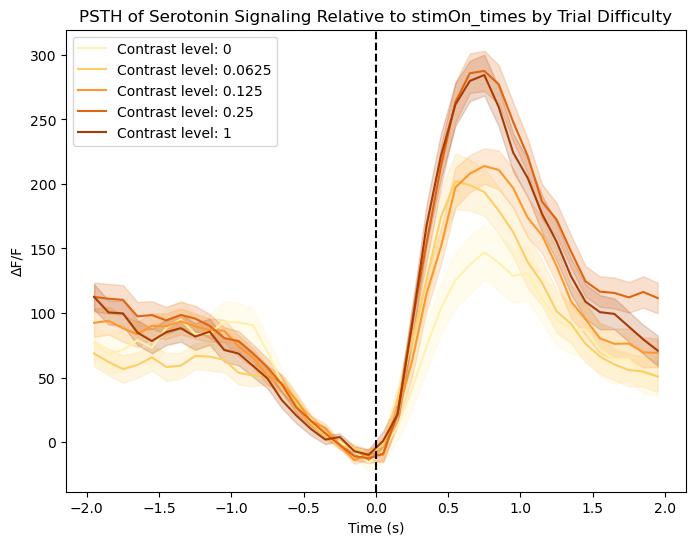

np.float64(5.23816138226817e-05)

In [54]:
# focus on one mouse: ZFM-03059
# extract all/some of its training session eids
mouse_df = metadf[metadf['subject']=='ZFM-03059']
train_idx = np.asarray(mouse_df['session_type']=='training').nonzero()
mouse_train_df = mouse_df.iloc[train_idx]
sessions = mouse_train_df['eid'][10:15]
sessions

params = Params(pre_time=2, post_time=2, bin_size=0.1, baseline_time=0.5)
session1 = Photometry(sessions.values[4])
psth_avg, tscale, psth_contrast = session1.get_psth('stimOn_times', contrast=[1, 0.0625, 0.25, 0.125, 0], params=params)

print(psth_avg)
print(psth_contrast)
 
# session1.plot_psth('stimOn_times', params=params)
session1.plot_psth_by_contrast_level('stimOn_times', contrast=[1, 0.0625, 0.25, 0.125, 0], params=params)
session1.fluctuations('stimOn_times', params=params)

              Region1G
times                 
-18.239284    0.009775
-18.172629    0.009869
-18.105942    0.009989
-18.039287    0.009890
-17.972632    0.009766
...                ...
 2784.150687  0.008516
 2784.217342  0.008444
 2784.283997  0.008486
 2784.350652  0.008537
 2784.417339  0.008502

[42043 rows x 1 columns]


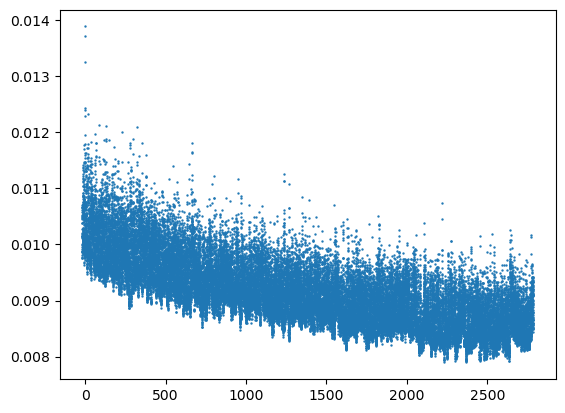

In [9]:
session1 = Photometry(eid=meta_train_df['eid'][2])
df = session1.load_photometry()
print(df)

plt.scatter(df.index, df, s=0.5)

In [24]:
# a quick check: plot for every trial the total activity during the baseline period, to see if you get a normal distribution. 
def plot_baseline():
       
        signal = session1.load_photometry().values
        times = list(session1.load_photometry().index)
        align_times = np.array(session1.load_trials()['firstMovement_times'])
        
        n_bins_pre = int(np.ceil(params.pre_time / params.bin_size))
        n_bins_post = int(np.ceil(params.post_time / params.bin_size))
        # n_bins = n_bins_pre + n_bins_post
        tscale = np.arange(-n_bins_pre, n_bins_post + 1) * params.bin_size
        ts = np.repeat(align_times[:, np.newaxis], tscale.size, axis=1) + tscale
        epoch_idxs = np.searchsorted(times, np.c_[ts[:, 0], ts[:, -1]])
        # bins = np.zeros(shape=(align_times.shape[0], n_bins))
        baseline = np.zeros(shape=(align_times.shape[0], ))

        for i, ep in enumerate(epoch_idxs):

            # Determine baseline period indices
            baseline_start = align_times[i] - params.baseline_time
            baseline_end = align_times[i]  # up to event onset
            baseline_idx = np.searchsorted(times, [baseline_start, baseline_end])

            # Compute baseline fluorescence (mean during baseline window)
            if baseline_idx[0] < baseline_idx[1]:  # ensure valid window
                F_baseline = np.mean(signal[baseline_idx[0]:baseline_idx[1]])
            else:
                F_baseline = np.nan  # if no points in baseline window
            
            baseline[i] = F_baseline
            
        plt.figure(figsize=(8, 6))
        plt.hist(baseline, bins=30)
        plt.show()


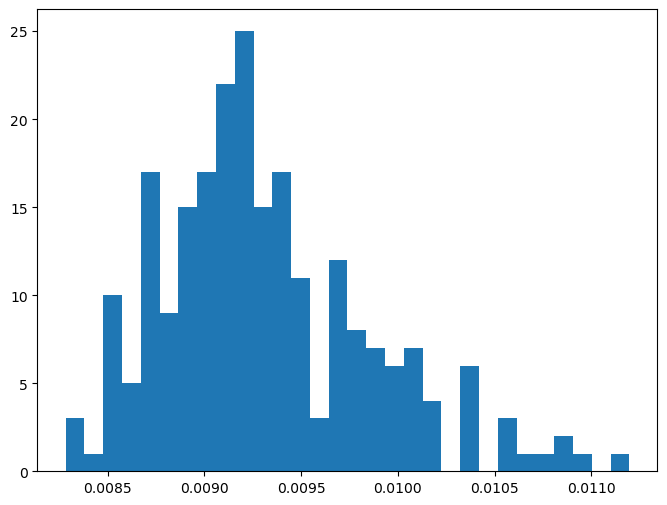

In [25]:
plot_baseline()

In [5]:
performance_df = pd.read_parquet('/Users/sarahhu/Downloads/performance_SERT_eid.parquet')
performance_df

,subject,session_num,stage,eid,n_trials,n_correct,proportion_correct
0,ZFM-03059,1,habituation,b105bea6-b3d4-46e2-af41-4e7e53277f27,96,96,1.000000
1,ZFM-03059,2,habituation,0fa78e73-a223-4e55-a524-a839262308e6,64,64,1.000000
2,ZFM-03059,3,training,ba01bf35-8a0d-4ca3-a66e-b3a540b21128,178,70,0.393258
3,ZFM-03059,4,training,00575787-7b8a-431a-a70e-1df857871a64,278,93,0.334532
4,ZFM-03059,5,training,12b299c1-69de-4c40-a8a3-c83d13d77a31,225,97,0.431111
...,...,...,...,...,...,...,...
575,ZFM-05248,65,bias,65b43acb-afa5-4590-a400-f7f4c79788ab,182,170,0.934066
576,ZFM-05248,66,bias,9c86d1db-cb3f-4bfe-bdd4-450c25b1b779,262,239,0.912214
577,ZFM-05248,67,bias,b46d38e4-cba5-4d2f-b975-93542a452317,113,101,0.893805
578,ZFM-05248,68,bias,f416af34-121d-419c-8d27-4e95f8648012,168,161,0.958333


Skipping 00575787-7b8a-431a-a70e-1df857871a64 due to error: [Errno 2] No such file or directory: '/Users/sarahhu/ibl_photometry/DR-5HT/00575787-7b8a-431a-a70e-1df857871a64_trials.pqt'
Skipping 12b299c1-69de-4c40-a8a3-c83d13d77a31 due to error: [Errno 2] No such file or directory: '/Users/sarahhu/ibl_photometry/DR-5HT/12b299c1-69de-4c40-a8a3-c83d13d77a31_trials.pqt'


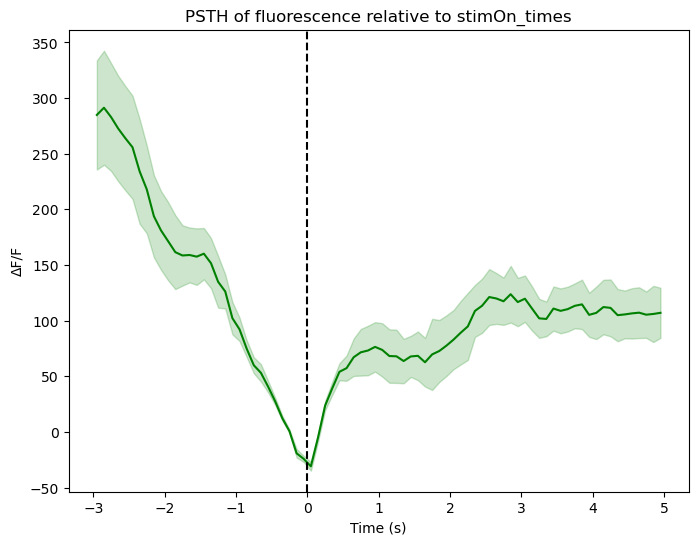

/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


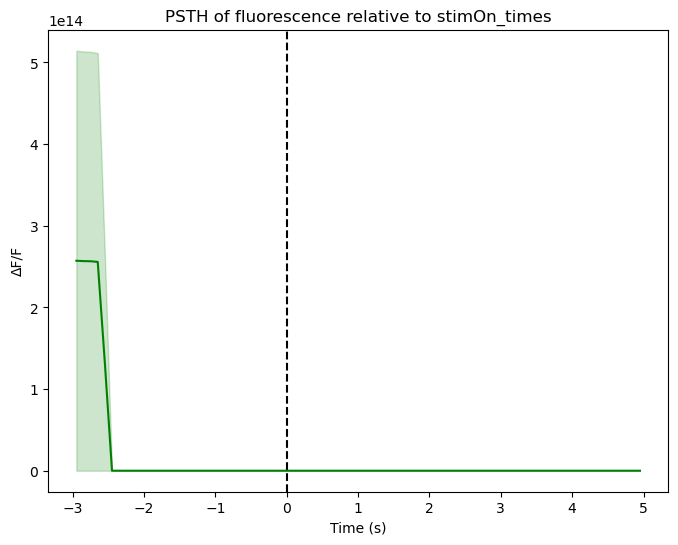

/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_38954/2660722652.py:252: RuntimeWarning: Mean of empty slice
  self.__bias_psth = np.nanmean(dF_F[bias_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_38954/2660722652.py:253: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__bias_psth_sem = stats.sem(dF_F[bias_idx], axis=0, nan_policy='omit')
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/num

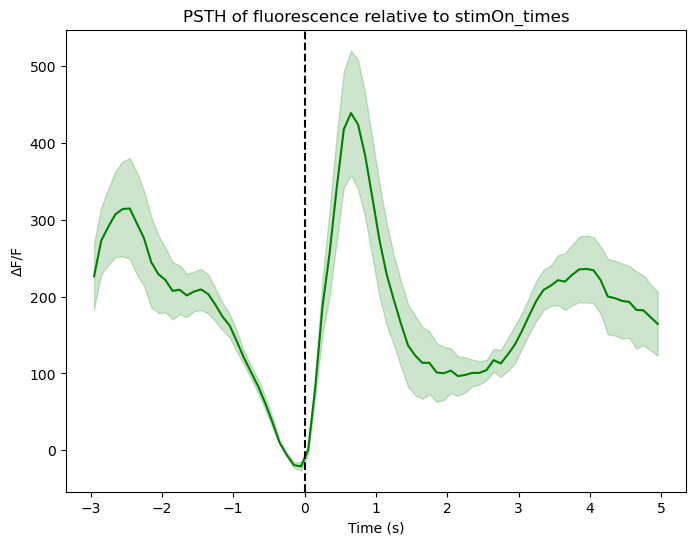

Skipping 00575787-7b8a-431a-a70e-1df857871a64 due to error: [Errno 2] No such file or directory: '/Users/sarahhu/ibl_photometry/DR-5HT/00575787-7b8a-431a-a70e-1df857871a64_trials.pqt'
Skipping 12b299c1-69de-4c40-a8a3-c83d13d77a31 due to error: [Errno 2] No such file or directory: '/Users/sarahhu/ibl_photometry/DR-5HT/12b299c1-69de-4c40-a8a3-c83d13d77a31_trials.pqt'


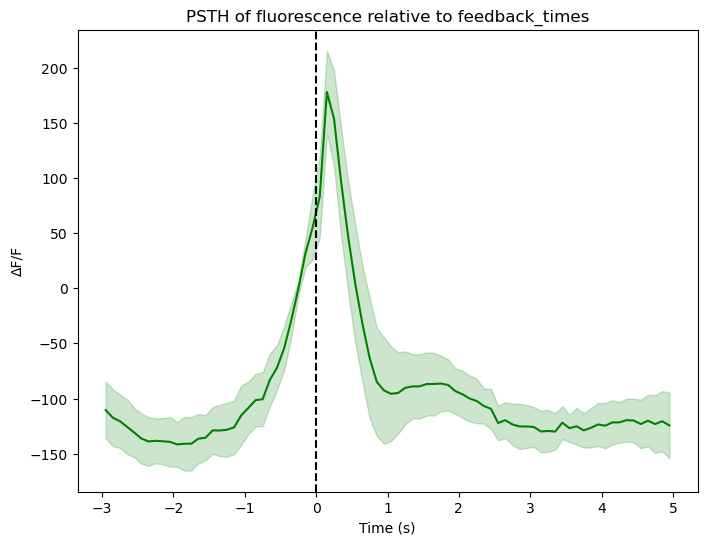

/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


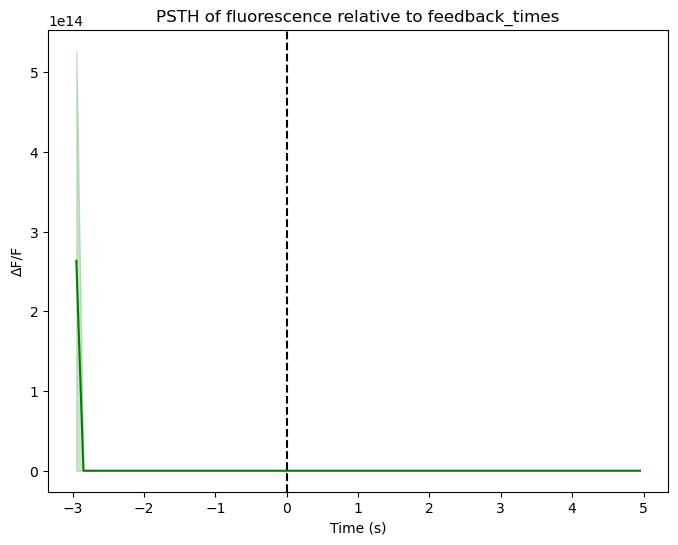

/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


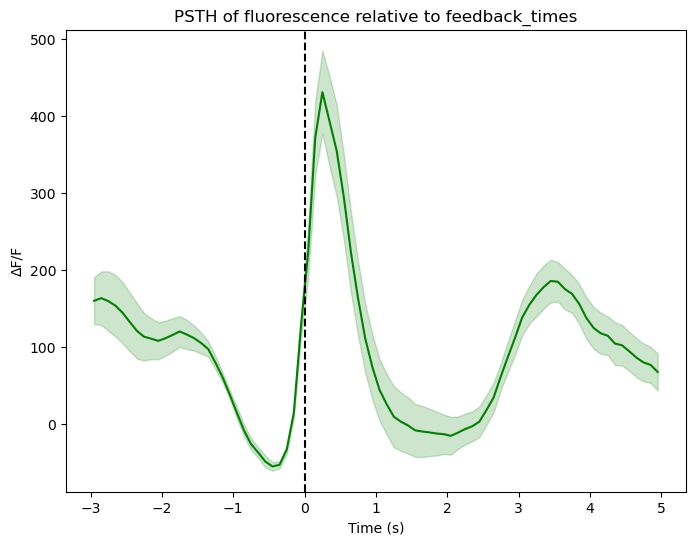

In [ ]:
# Separate into three training phases, see if the responses change to both stimulus onset 
performance_df
eids_early = list(performance_df[(performance_df['subject']=='ZFM-03059') & (performance_df['stage']=='training')
                            & (performance_df['session_num'].between(3, 8))]['eid'].values)
eids_middle = list(performance_df[(performance_df['subject']=='ZFM-03059') & (performance_df['stage']=='training')
                            & (performance_df['session_num'].between(9, 15))]['eid'].values)
eids_late = list(performance_df[(performance_df['subject']=='ZFM-03059') & (performance_df['stage']=='training')
                            & (performance_df['session_num'].between(16, 25))]['eid'].values)
print(eids_early)
print(eids_middle)
print(eids_late)

Photometry.sessions_plot(eids=eids_early, events='stimOn_times', params=params)
Photometry.sessions_plot(eids=eids_middle, events='stimOn_times', params=params)
Photometry.sessions_plot(eids=eids_late, events='stimOn_times', params=params)

Photometry.sessions_plot(eids=eids_early, events='feedback_times', params=params)
Photometry.sessions_plot(eids=eids_middle, events='feedback_times', params=params)
Photometry.sessions_plot(eids=eids_late, events='feedback_times', params=params)

# Photometry.sessions_plot(eids=eids_early, events='feedback_times', params=params, trial_idx=[1, 20])

In [8]:
bias_df = performance_df[(performance_df['stage']=='bias') & (performance_df['subject']=='ZFM-03059')&(performance_df['n_trials']>90)]
valid_eids = bias_df['eid'].isin(metadf['eid'])
bias_df_valid = bias_df[valid_eids]
bias_df_valid

,subject,session_num,stage,eid,n_trials,n_correct,proportion_correct
24,ZFM-03059,25,bias,b387dd2b-61c4-4e2f-9572-389d40f93fc3,187,185,0.989305
25,ZFM-03059,26,bias,7f3b9633-851a-47e5-b7f8-c92bbbb01cc5,143,140,0.979021
26,ZFM-03059,27,bias,f6d846da-6a63-4c5a-9d32-f572ef565e4f,236,236,1.000000
27,ZFM-03059,28,bias,8e90ac76-47c7-441b-b370-204a8002abd8,127,127,1.000000
28,ZFM-03059,29,bias,b2f1186e-8c04-46c9-b4a7-e5e9785ff0ca,184,184,1.000000
29,ZFM-03059,30,bias,934798fb-006b-4cd4-a546-1b896aa4c212,212,209,0.985849
31,ZFM-03059,32,bias,5c5a5525-cde9-41bc-95b9-90a3a0c7bce3,178,178,1.000000
32,ZFM-03059,33,bias,94e1f61f-57e2-4792-a901-d0baa7096b87,114,114,1.000000
33,ZFM-03059,34,bias,075a551f-ae82-4b9a-b659-fe94b638b7aa,100,92,0.920000
46,ZFM-03059,47,bias,bff3ba86-e4be-4b6b-a0ed-056263859c00,120,101,0.841667


In [157]:
# trials with 80-20 probability left
bias_session27_prob = Photometry(eid='f6d846da-6a63-4c5a-9d32-f572ef565e4f', 
                                 trial_idx=[840, 960])
params = Params(pre_time=5, post_time=8, bin_size=0.1, baseline_time=0.5)
# bias_session27_prob.get_psth('feedback_times', params, bias=0)
bias_session27_prob.get_psth('feedback_times', params, side='left', contrast=[0, 1], bias=1, feedback_type=-1.0)
# bias_session27_prob.plot_psth('feedback_times', params)
# bias_session27.plot_psth_by_contrast_level(events='response_times', contrast=[0.0625, 0.125, 0.25, 1], params=params)

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_4777/4221953058.py:247: RuntimeWarning: Mean of empty slice
  self.__no_bias_psth = np.nanmean(dF_F[no_bias_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_4777/4221953058.py:248: SmallSampleWarning: All axis-slices of one or more sample arguments are too small; all elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__no_bias_psth_sem = stats.sem(dF_F[no_bias_idx], axis=0, nan_policy='omit')


(array([-11589.86970874, -15593.52160452, -16099.29851211, -24774.47109538,
        -25467.3440156 , -29377.75549999, -28171.35490967, -29758.03597791,
        -34319.13762797, -28179.5624915 , -20274.60201631, -28306.72110354,
        -35182.86649985, -28959.35202983, -36395.79185285, -33717.94785915,
        -37956.44168885, -33348.79522303, -31465.52877299, -36905.6525221 ,
        -37579.53620094, -45798.76020436, -44656.75524591, -34068.9518774 ,
        -33818.8863878 , -21936.91353101, -22895.43660941, -13879.69551923,
        -11332.93897262,  -4600.44562901,  -6028.29326341, -16496.25426942,
        -17622.8709438 , -17742.22979123, -15693.70534512, -14435.70750647,
        -24091.59202873, -26919.49799972, -22090.70596084, -16328.44080328,
        -16754.51945962, -23075.27470188, -18894.996392  , -19425.90562425,
        -11148.18016448, -11247.14083304,  -6637.99585209,  -4265.90866276,
          5546.62097534,  18192.01560534,   3629.57315551,  42265.09521085,
         481

In [14]:
# load session and params
bias_session27 = Photometry(eid='b387dd2b-61c4-4e2f-9572-389d40f93fc3', trial_idx=None)
params = Params(pre_time=2, post_time=3, bin_size=0.05, baseline_time=0.5)

# stimulus onset times
# this shows some difference between full contrast (1) trials and other trials, and also 80-20 has much higher activity than 50-50. 
# bias_session27.get_psth('stimOn_times', params)
# bias_session27.plot_psth_by_contrast_level('stimOn_times', contrast=[0, 0.0625, 0.125, 0.25, 1], params=params)
# bias_session27.plot_psth_by_bias('stimOn_times', params)
# bias_session27.plot_psth_by_side('stimOn_times', params)
# bias_session27.plot_psth_by_feedback_type('stimOn_times', params)

# go-cue times
# this shows some difference between full contrast (1) trials and other trials, and also 80-20 has much higher activity than 50-50. 
# (very similar to stimOn times!)
# bias_session27.get_psth('goCue_times', params)
# bias_session27.plot_psth_by_contrast_level('goCue_times', contrast=[0, 0.0625, 0.125, 0.25, 1], params=params)
# bias_session27.plot_psth_by_bias('goCue_times', params)
# bias_session27.plot_psth_by_side('goCue_times', params)
# bias_session27.plot_psth_by_feedback_type('goCue_times', params)

# first movement times
# no significant difference between contrast levels, 80-20 again has much higher activity than 50-50, also incorrect much higher than correct. 
# bias_session27.get_psth('firstMovement_times', params)
# bias_session27.plot_psth_by_contrast_level('firstMovement_times', contrast=[0, 0.0625, 0.125, 0.25, 1], params=params)
# bias_session27.plot_psth_by_bias('firstMovement_times', params)
# bias_session27.plot_psth_by_side('firstMovement_times', params)
# bias_session27.plot_psth_by_feedback_type('firstMovement_times', params)

# response times
# left and right are a bit different (not too strange), 80-20 again has higher activity than 50-50, and incorrect higher than correct. 
# bias_session27.get_psth('response_times', params)
# bias_session27.plot_psth_by_contrast_level('response_times', contrast=[0, 0.0625, 0.125, 0.25, 1], params=params)
# bias_session27.plot_psth_by_bias('response_times', params)
# bias_session27.plot_psth_by_side('response_times', params)
# bias_session27.plot_psth_by_feedback_type('response_times', params)

# feedback times
# left and right are a bit different (not too strange), 80-20 again has higher activity than 50-50, and incorrect higher than correct. 
# (very similar to response times!)
# bias_session27.get_psth('feedback_times', params)
# bias_session27.plot_psth_by_contrast_level('feedback_times', contrast=[0, 0.0625, 0.125, 0.25, 1], params=params)
# bias_session27.plot_psth_by_bias('feedback_times', params)
# bias_session27.plot_psth_by_side('feedback_times', params)
# bias_session27.plot_psth_by_feedback_type('feedback_times', params)


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_38954/2660722652.py:242: RuntimeWarning: Mean of empty slice
  self.__incorrect_psth = np.nanmean(dF_F[incorrect_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_38954/2660722652.py:243: SmallSampleWarning: All axis-slices of one or more sample arguments are too small; all elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__incorrect_psth_sem = stats.sem(dF_F[incorrect_idx], axis=0, nan_policy='omit')


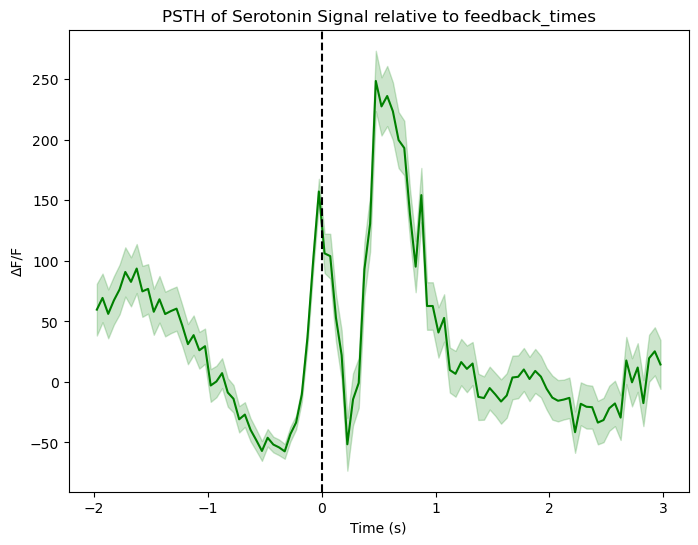

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_38954/2660722652.py:239: RuntimeWarning: Mean of empty slice
  self.__correct_psth = np.nanmean(dF_F[correct_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_38954/2660722652.py:240: SmallSampleWarning: All axis-slices of one or more sample arguments are too small; all elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__correct_psth_sem = stats.sem(dF_F[correct_idx], axis=0, nan_policy='omit')


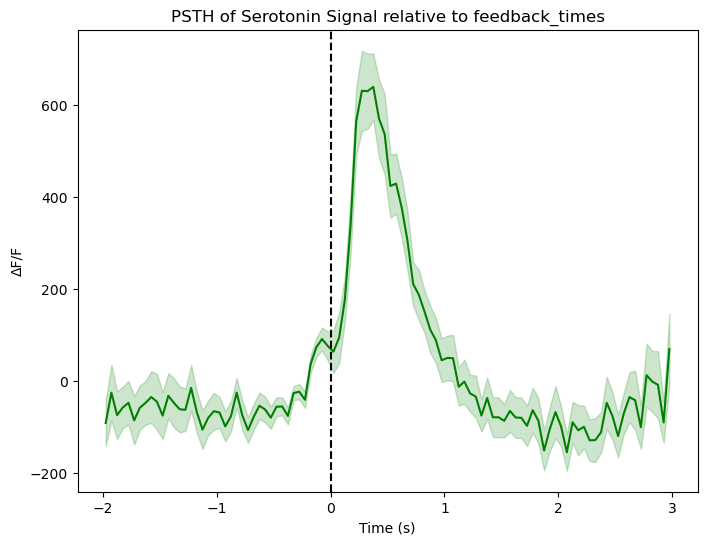

In [15]:
# signed or unsigned RPE: separate the trials into correct/incorrect
# preliminarily, seems like it does encode "error"
# passing in trial_idx allows for plotting on separate graphs, whereas "plot_by_feedback_type" automatically plots both correct and incorrect
# on the same graph. The information is the same though. 

bias_session27_correct_idx = list(bias_session27.feedbackType==1)
bias_session27_incorrect_idx = list(bias_session27.feedbackType==-1)

# correct trials, align to feedback time
bias_session27_correct = Photometry(eid='b387dd2b-61c4-4e2f-9572-389d40f93fc3', trial_idx=bias_session27_correct_idx)
bias_session27_correct.get_psth('feedback_times', params)
bias_session27_correct.plot_psth('feedback_times', params)

# incorrect trials, align to feedback time
bias_session27_incorrect = Photometry(eid='b387dd2b-61c4-4e2f-9572-389d40f93fc3', trial_idx=bias_session27_incorrect_idx)
bias_session27_incorrect.get_psth('feedback_times', params)
bias_session27_incorrect.plot_psth('feedback_times', params)

## Statistical Analysis

### Linear regression (response vs. contrast level)

In [4]:
# function to compute basic statistics and plots
# stats packages
from scipy import stats
from scipy.stats import t

params = Params(pre_time=5, post_time=8, bin_size=0.1, baseline_time=0.5)

def get_best_fit_line(eid, params, events):
    
    session = Photometry(eid)
    contrast_levels = session.contrastLeft.unique()
    contrast_levels = list(contrast_levels[~np.isnan(contrast_levels)])
    contrast_levels.sort()
    # print(contrast_levels)

    if len(contrast_levels) <= 2: 
        print("Skipping session with less than three contrast levels.")
        return None

    # compute the response for each contrast level
    response = []
    psth, tscale, psth_contrast = session.get_psth(events=events, params=params, contrast=contrast_levels)
    time_onset = np.searchsorted(tscale, 0)
    
    # sum up 1s to 2s after event depending on contrast levels
    for c_l in contrast_levels:
        if c_l in contrast_levels[:2]:
            time_period = int(np.floor(2.0 / params.bin_size))
        else:
            time_period = int(np.floor(1.0 / params.bin_size))
        response_mag = np.nanmean(psth_contrast.get(c_l)[time_onset:time_onset + time_period])
        response.append(response_mag)
        # print(f"response magnitude for contrast level {c_l} is {response_mag}.")

    x = contrast_levels
    y = response
    res = stats.linregress(x, y)
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
    print(f"intercept (95%): {res.intercept:.6f}"
        f" +/- {ts*res.intercept_stderr:.6f}")
    print(f"R-squared: {res.rvalue**2:.6f}")

    # returns slope, intercept, C.I. of slope, C.I. of intercept, and R^2
    return res.slope, res.intercept, ts*res.stderr, ts*res.intercept_stderr, res.rvalue**2, contrast_levels, response

def get_line(x, slope, intercept):
    return slope * np.array(x) + intercept

def plot_best_fit_line(eid, events):
    slope, intercept, ci_slope, ci_intercept, r_sqr, contrast_levels, response = get_best_fit_line(
                                                                eid, params=params, events=events)
    x = contrast_levels
    y = response
    mymodel = list(get_line(x, slope, intercept))
    plt.scatter(x, y, label='original data')
    plt.plot(x, mymodel, 'r', label='fitted line')
    plt.legend()
    plt.show()

def load_trials(eid):
    df = pd.read_parquet('/Users/sarahhu/ibl_photometry/DR-5HT/' + eid + '_trials.pqt')
    return df

def load_photometry(eid):
    df = pd.read_parquet('/Users/sarahhu/ibl_photometry/DR-5HT/' + eid + '_gcamp.pqt')
    return df

slope (95%): 187.056973 +/- 74.616848
intercept (95%): 150.800908 +/- 34.711374
R-squared: 0.954989


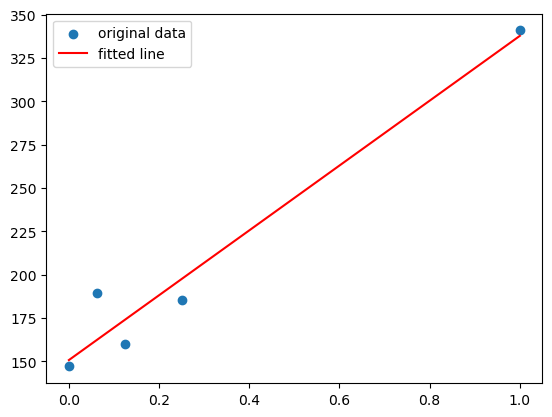

In [ ]:
# get_best_fit_line(eid='b387dd2b-61c4-4e2f-9572-389d40f93fc3', params=params)
plot_best_fit_line(eid='b387dd2b-61c4-4e2f-9572-389d40f93fc3', events='stimOn_times')

In [5]:
all_samples = metadf['eid'].values
all_samples

array(['fe2a712b-014b-47e7-b2ac-f85d0571cf44',
       'ba01bf35-8a0d-4ca3-a66e-b3a540b21128',
       'f2a6559d-1e45-4e83-8f65-1295ef50ed4b',
       'c5cdd496-7400-4c0f-b326-55016bce4fcf',
       'fd22820d-a2c2-4c06-b90e-f399344e1c0a',
       '92bf91b5-75db-4e95-8623-fd32c615558f',
       '272c7a84-1f76-4305-a355-4e2149726a9d',
       '48c4f78b-92f7-4ee2-b9c1-5f807197b5e9',
       'e04536b2-b161-478e-af3a-d04bc1ab33ee',
       'df775d7e-3890-4aa3-b7ef-0c6fe6f9abf8',
       '9557f20a-e1ef-44d5-9859-20d1c3854175',
       '26d6c415-23b0-4c49-b73e-b6cf2693df4d',
       '4edc1662-a165-48ef-a332-7172bfca71e7',
       '38c3ebde-c45d-442e-ac61-f42161cfc984',
       'dd549116-68a1-462d-90ef-f4e0ec5c69fc',
       '32eaad6d-fd35-46e9-b7cb-22656d8e3375',
       '68f894bf-2268-4773-aa8d-ac8ab168320e',
       '72e564aa-8416-48fb-a2b9-f9d23e6c7e4b',
       'e9bdcf2b-d0db-42f8-8dfe-3bb82711ff68',
       'a44f72af-755f-4d58-b9bb-c5b345bcd788',
       'f869242e-d1f9-4b7e-a83d-7c794ca6ebbe',
       '4aaa7

In [ ]:
slopes = []
r_squared = []

for eid in all_samples:
    results = get_best_fit_line(eid, params=params, events='stimOn_times')
    if results is not None:
        slope = results[0]
        r_sqr = results[4]
        slopes.append(slope)
        r_squared.append(r_sqr)

Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
slope (95%): 8639.307804 +/- 208845.863923
intercept (95%): -821.334483 +/- 138138.554571
R-squared: 0.216468
Skipping session with less than three contrast levels.
slope (95%): -4648.098816 +/- 92187.096499
intercept (95%): 1687.891502 +/- 60976.032856
R-squared: 0.290998
Skipping session with less than three contrast levels.
slope (95%): 3002.212550 +/- 49049.983598
intercept (95%): 14364.300762 +/- 32443.514603
R-squared: 0.376883
Skipping session with less than three contrast levels.
slope (95%): -30857.040337 +/- 8096.067191
intercept (95%): 30087.9

/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


slope (95%): 27175.024618 +/- 90903.603072
intercept (95%): -4808.508884 +/- 60127.081752
R-squared: 0.935183
slope (95%): 9385.489435 +/- 32957.657053
intercept (95%): 31299.826693 +/- 21799.441090
R-squared: 0.929042
slope (95%): 37732.205086 +/- 44419.471723
intercept (95%): 14108.434924 +/- 22926.913576
R-squared: 0.708964
slope (95%): 17001.104678 +/- 207622.800231
intercept (95%): 28520.211854 +/- 137329.573980
R-squared: 0.519813
slope (95%): -6986.935748 +/- 32595.177960
intercept (95%): 19913.477736 +/- 15358.009721
R-squared: 0.081346
slope (95%): -53675.786997 +/- 138746.512325
intercept (95%): 142194.878020 +/- 79948.727417
R-squared: 0.580772
slope (95%): 20112.965064 +/- 33508.569159
intercept (95%): 29714.728595 +/- 15788.376168
R-squared: 0.409792
slope (95%): -40590.571433 +/- 82272.665360
intercept (95%): 75385.443952 +/- 38764.764406
R-squared: 0.319307


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


slope (95%): -23479.752900 +/- 434405.453794
intercept (95%): 80843.019454 +/- 202083.180633
R-squared: 0.009766
slope (95%): -10712.581213 +/- 95309.567905
intercept (95%): 77648.585637 +/- 44337.520302
R-squared: 0.040905
slope (95%): 14714.893667 +/- 36699.362267
intercept (95%): 20278.094074 +/- 17072.354385
R-squared: 0.351806
slope (95%): 2259.163068 +/- 62995.000319
intercept (95%): 69936.795053 +/- 29304.949828
R-squared: 0.004323
slope (95%): 61335.456062 +/- 53556.269975
intercept (95%): 70080.093665 +/- 24914.101066
R-squared: 0.815769
slope (95%): -77369.701135 +/- 841149.937102
intercept (95%): 167393.809298 +/- 556368.387222
R-squared: 0.577332
slope (95%): 29346.629380 +/- 36090.815276
intercept (95%): 41728.012799 +/- 16789.261458
R-squared: 0.690609
slope (95%): 25807.698157 +/- 8372.209880
intercept (95%): 41527.363209 +/- 3894.708933
R-squared: 0.969769


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


slope (95%): 27057.087462 +/- 19127.528356
intercept (95%): 62534.226383 +/- 8898.027716
R-squared: 0.871056
slope (95%): 9149.343203 +/- 10982.255203
intercept (95%): 36126.005025 +/- 5108.888580
R-squared: 0.700880


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:253: RuntimeWarning: Mean of empty slice
  self.__bias_psth = np.nanmean(dF_F[bias_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:254: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__bias_psth_sem = stats.sem(dF_F[bias_idx], axis=0, nan_policy='omit')


slope (95%): -20208.926336 +/- 148188.201776
intercept (95%): 10563.080965 +/- 68936.388541
R-squared: 0.059076
slope (95%): 43370.058961 +/- 72807.730718
intercept (95%): 235612.078466 +/- 33869.781490
R-squared: 0.545023


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


slope (95%): 4414.299231 +/- 36336.303553
intercept (95%): 50023.076983 +/- 16903.461341
R-squared: 0.047460
slope (95%): -2863.694524 +/- 20034.916664
intercept (95%): 32353.395050 +/- 9320.140085
R-squared: 0.064523
slope (95%): 2508.890232 +/- 8011.698281
intercept (95%): 1502.136261 +/- 3727.000793
R-squared: 0.248723


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:254: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__bias_psth_sem = stats.sem(dF_F[bias_idx], axis=0, nan_policy='omit')


slope (95%): 63018.425458 +/- 72511.795312
intercept (95%): -3620.533776 +/- 33732.113863
R-squared: 0.718300


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


slope (95%): -9073.999433 +/- 17507.692953
intercept (95%): 4527.554406 +/- 8144.488626
R-squared: 0.475578
slope (95%): 40000.961883 +/- 55778.171392
intercept (95%): 30493.903167 +/- 25947.718166
R-squared: 0.634537
slope (95%): -3951.809234 +/- 44211.610014
intercept (95%): -1949.085989 +/- 20567.013362
R-squared: 0.026264
slope (95%): 60765.253519 +/- 42759.787658
intercept (95%): 74336.066755 +/- 19891.633076
R-squared: 0.872086


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


slope (95%): -154157262701656.031250 +/- 142585733296348.156250
intercept (95%): 212846329135647.500000 +/- 66330149047945.906250
R-squared: 0.797824
slope (95%): 56551.060343 +/- 26926.925153
intercept (95%): 14655.681623 +/- 12526.266952
R-squared: 0.937069


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


slope (95%): 19200.166764 +/- 48185.354439
intercept (95%): -4282.325340 +/- 22415.578810
R-squared: 0.348967
slope (95%): 45325.053897 +/- 30197.190224
intercept (95%): 56394.742131 +/- 14047.577427
R-squared: 0.883799
slope (95%): -4138.664313 +/- 18677.786290
intercept (95%): 2624.948102 +/- 8688.810022
R-squared: 0.142188
slope (95%): 591.470157 +/- 77043.499470
intercept (95%): -20361.815065 +/- 35840.239306
R-squared: 0.000199
slope (95%): 31563.070417 +/- 27916.901586
intercept (95%): -1247.605237 +/- 12986.798892
R-squared: 0.811869
slope (95%): -7006.798951 +/- 47188.313611
intercept (95%): -401.357149 +/- 21951.760550
R-squared: 0.069277


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:247: RuntimeWarning: Mean of empty slice
  self.__no_bias_psth = np.nanmean(dF_F[no_bias_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:248: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__no_bias_psth_sem = stats.sem(dF_F[no_bias_idx], axis=0, nan_policy='omit')


slope (95%): 14031.989243 +/- 23515.078222
intercept (95%): -5691.053907 +/- 10939.093325
R-squared: 0.545891
slope (95%): -2524.198608 +/- 35271.666850
intercept (95%): -27456.476756 +/- 16408.197828
R-squared: 0.016996
slope (95%): 189648460992366.937500 +/- 372560633477254.187500
intercept (95%): 94418171510608.687500 +/- 173313288620414.343750
R-squared: 0.466608
slope (95%): 13539.241460 +/- 27775.368437
intercept (95%): 15525.181677 +/- 12920.958400
R-squared: 0.445115


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:247: RuntimeWarning: Mean of empty slice
  self.__no_bias_psth = np.nanmean(dF_F[no_bias_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:248: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__no_bias_psth_sem = stats.sem(dF_F[no_bias_idx], axis=0, nan_policy='omit')


slope (95%): -1321939690776.001221 +/- 47313622183319.992188
intercept (95%): 5094975876406.233398 +/- 22010053452508.996094
R-squared: 0.002629
slope (95%): 24116.952804 +/- 58979.857365
intercept (95%): 37685.190181 +/- 27437.125997
R-squared: 0.360805
slope (95%): -6566.684311 +/- 24462.857564
intercept (95%): 4809.242649 +/- 11379.995396
R-squared: 0.195666
slope (95%): 5986.696480 +/- 19647.537522
intercept (95%): -4402.252618 +/- 9139.933303
R-squared: 0.238642
slope (95%): 9708.769794 +/- 11785.234330
intercept (95%): -2185.904120 +/- 5482.430336
R-squared: 0.696155
slope (95%): 109962.477486 +/- 46754.861864
intercept (95%): 81662.751507 +/- 21750.121029
R-squared: 0.949171
slope (95%): -15139.194430 +/- 36247.877094
intercept (95%): 10933.392039 +/- 16862.325808
R-squared: 0.370634
slope (95%): 6028.569097 +/- 19448.928497
intercept (95%): 5955.476268 +/- 9047.541407
R-squared: 0.244923
slope (95%): 28.688856 +/- 12716.826672
intercept (95%): 3500.037626 +/- 5915.802297
R-squa

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:247: RuntimeWarning: Mean of empty slice
  self.__no_bias_psth = np.nanmean(dF_F[no_bias_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:248: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__no_bias_psth_sem = stats.sem(dF_F[no_bias_idx], axis=0, nan_policy='omit')


slope (95%): 2360.515145 +/- 9957.365837
intercept (95%): -2351.095423 +/- 4632.115323
R-squared: 0.159470
slope (95%): -7590547039552.761719 +/- 24256965462612.035156
intercept (95%): 6727090375740.061523 +/- 11284215449815.558594
R-squared: 0.248447
slope (95%): 3220.401069 +/- 5213.239474
intercept (95%): -31.698241 +/- 2425.172164
R-squared: 0.562988
slope (95%): 12942.712788 +/- 27182.749013
intercept (95%): 13375.158416 +/- 12645.274895
R-squared: 0.433543
slope (95%): 912.685817 +/- 1199.205233
intercept (95%): -1651.207902 +/- 557.864101
R-squared: 0.661647
slope (95%): 2064.619653 +/- 8623.365677
intercept (95%): 1374.320856 +/- 4011.545317
R-squared: 0.162143
slope (95%): 4096.731453 +/- 9184.733333
intercept (95%): 4250.898089 +/- 4272.690660
R-squared: 0.401789
slope (95%): 1132.494336 +/- 16130.318853
intercept (95%): 14516.808820 +/- 7503.741286
R-squared: 0.016369
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:253: RuntimeWarning: Mean of empty slice
  self.__bias_psth = np.nanmean(dF_F[bias_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:254: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__bias_psth_sem = stats.sem(dF_F[bias_idx], axis=0, nan_policy='omit')


slope (95%): 5205.520142 +/- 18623.682514
intercept (95%): -8312.556559 +/- 8663.641224
R-squared: 0.208706


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:280: RuntimeWarning: Mean of empty slice
  psth_contrast[level] = np.nanmean(trials[idx], axis=0) # store for this level
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:282: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self._psth_contrast_sem[level] = stats.sem(trials[idx], axis=0, nan_policy='omit')


slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan
slope (95%): 4000.974590 +/- 10683.837786
intercept (95%): -3247.953324 +/- 4970.066334
R-squared: 0.321323
slope (95%): 3215.153731 +/- 6390.981179
intercept (95%): 59.851194 +/- 2973.051542
R-squared: 0.460747
slope (95%): -818.186793 +/- 12444.754530
intercept (95%): 6806.924842 +/- 5789.235737
R-squared: 0.014383
slope (95%): -23471.441686 +/- 18542.894640
intercept (95%): 5231.467798 +/- 8626.059121
R-squared: 0.843972
slope (95%): 21453.630819 +/- 86225.505406
intercept (95%): -11584.632354 +/- 57032.810994
R-squared: 0.909046
slope (95%): -476.729891 +/- 5904.321365
intercept (95%): -5264.125781 +/- 2746.659901
R-squared: 0.021535
slope (95%): -4010.109661 +/- 10933.478269
intercept (95%): -5387.216951 +/- 5086.197801
R-squared: 0.312312
slope (95%): -52984387917613.226562 +/- 64227626051341.109375
intercept (95%): 160026169298711.937500 +/- 42482581457975.500000
R-squared: 0.990981
slope (95%): -7264461427152.

/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


slope (95%): 13802.384605 +/- 5911.798480
intercept (95%): -7893.387365 +/- 2750.138217
R-squared: 0.948459


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:254: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__bias_psth_sem = stats.sem(dF_F[bias_idx], axis=0, nan_policy='omit')


slope (95%): 5475.393734 +/- 6904.985212
intercept (95%): -14183.733047 +/- 3212.163571
R-squared: 0.679773
slope (95%): -6726.234864 +/- 89910.267205
intercept (95%): 8209.585119 +/- 59470.051834
R-squared: 0.474669
slope (95%): -1053.231511 +/- 6771.149949
intercept (95%): -2909.983247 +/- 3149.904096
R-squared: 0.075513


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


slope (95%): 53717.782116 +/- 20870.889700
intercept (95%): 7667.070343 +/- 9709.030438
R-squared: 0.957200
slope (95%): 4676.039576 +/- 15139.895795
intercept (95%): -1776.630453 +/- 7043.001578
R-squared: 0.243594
slope (95%): 6644.745665 +/- 10146.624834
intercept (95%): 1860.643735 +/- 4720.157634
R-squared: 0.591473
slope (95%): 21753.465092 +/- 31585.434190
intercept (95%): -988.783532 +/- 14693.381372
R-squared: 0.615583
slope (95%): 2774.238347 +/- 14024.484502
intercept (95%): 1798.558163 +/- 6524.117987
R-squared: 0.116689
slope (95%): -2072.321609 +/- 8159.461223
intercept (95%): 1989.391821 +/- 3795.739353
R-squared: 0.178825
slope (95%): 57928.022792 +/- 40207.239554
intercept (95%): -3930.756251 +/- 18704.200840
R-squared: 0.875119
slope (95%): 53149.650642 +/- 61610.571809
intercept (95%): 23154.337457 +/- 28660.920813
R-squared: 0.715296
slope (95%): 5969.279121 +/- 18875.430794
intercept (95%): -5177.577075 +/- 8780.753228
R-squared: 0.252413
slope (95%): 37613.749686 

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:233: RuntimeWarning: Mean of empty slice
  self.__left_psth = np.nanmean(dF_F[left_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__left_psth_sem = stats.sem(dF_F[left_idx], axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:236: RuntimeWarning: Mean of empty slice
  self.__right_psth = np.nanmean(dF_F[right_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:237: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation fo

slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:233: RuntimeWarning: Mean of empty slice
  self.__left_psth = np.nanmean(dF_F[left_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__left_psth_sem = stats.sem(dF_F[left_idx], axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:236: RuntimeWarning: Mean of empty slice
  self.__right_psth = np.nanmean(dF_F[right_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:237: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation fo

slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:233: RuntimeWarning: Mean of empty slice
  self.__left_psth = np.nanmean(dF_F[left_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__left_psth_sem = stats.sem(dF_F[left_idx], axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:236: RuntimeWarning: Mean of empty slice
  self.__right_psth = np.nanmean(dF_F[right_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_23136/4221953058.py:237: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation fo

slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan
slope (95%): 1018.242878 +/- 15403.292754
intercept (95%): 6573.035159 +/- 7165.532487
R-squared: 0.014538
slope (95%): 2165.158999 +/- 9524.708516
intercept (95%): 1314.172575 +/- 4430.845365
R-squared: 0.148539
slope (95%): 1707.916758 +/- 11252.351582
intercept (95%): 2170.914559 +/- 5234.536025
R-squared: 0.072164
slope (95%): 5821.513849 +/- 12693.878956
intercept (95%): 2006.463887 +/- 5905.127138
R-squared: 0.415219
slope (95%): -2122.342576 +/- 5451.129946
intercept (95%): 1055.831500 +/- 2535.837586
R-squared: 0.338515
slope (95%): 30322.313865 +/- 11525.679024
intercept (95%): 22179.264612 +/- 5361.686544
R-squared: 0.958960
slope (95%): 21314.128373 +/- 38916.860446
intercept (95%): 29801.100533 +/- 18103.923122
R-squared: 0.503143
slope (95%): 4376.662324 +/- 8557.829495
intercept (95%): 674.399618 +/- 3981.058222
R-squared: 0.468932
slope (95%): 1898.225387 +/- 14730.744449
intercept (95%): 1618.894611 +/

In [50]:
slopes
filtered_slopes = [s for s, r2 in zip(slopes, r_squared) if r2 > 0.2]
print(filtered_slopes)

# Perform a one-sample t-test against 0
t_stat, p_two_tailed = stats.ttest_1samp(filtered_slopes, popmean=0)

# Convert to one-tailed p-value for testing if mean > 0
if t_stat > 0:
    p_one_tailed = p_two_tailed / 2
else:
    p_one_tailed = 1 - (p_two_tailed / 2)

print(np.nanmean(filtered_slopes))
print(np.nanstd(filtered_slopes))
print(f"t-statistic: {t_stat:.4f}")
print(f"One-tailed p-value (testing if mean > 0): {p_one_tailed:.4f}")

[np.float64(8639.307803530359), np.float64(-4648.098816435473), np.float64(3002.2125495357886), np.float64(-30857.0403365603), np.float64(-23353.681867867348), np.float64(27175.024617891373), np.float64(9385.489434810908), np.float64(37732.205085902846), np.float64(17001.10467823804), np.float64(-53675.78699746439), np.float64(20112.96506375497), np.float64(-40590.57143303341), np.float64(14714.893666906173), np.float64(61335.45606166539), np.float64(-77369.7011353134), np.float64(29346.629379533355), np.float64(25807.698157497856), np.float64(27057.08746187277), np.float64(9149.343203490436), np.float64(43370.05896118085), np.float64(2508.8902319140857), np.float64(63018.425458070735), np.float64(-9073.999433458488), np.float64(40000.96188250584), np.float64(60765.25351914408), np.float64(-154157262701656.03), np.float64(56551.060342725585), np.float64(19200.166764027093), np.float64(45325.05389698116), np.float64(31563.070417103772), np.float64(14031.989243020793), np.float64(1896484

In [125]:
slopes1 = []
ci_slopes1 = []
r_squared1 = []
contrast1 = []
responses1 = []
idx = 0

for eid in all_samples:
    results = get_best_fit_line(eid, params=params, events='stimOn_times')
    if results is not None:
        slope1 = results[0]
        ci_slope1 = results[2]
        r_sqr1 = results[4]
        contrast = results[5]
        response1 = results[6]
        slopes1.append(slope1)
        ci_slopes1.append(ci_slope1)
        r_squared1.append(r_sqr1)
        contrast1.append(contrast)
        responses1.append(response1)
        print(f'completed session {idx + 1}/269 with eid {eid}')
    idx += 1
        
print(f'slopes: {slopes1}')
print(f'responses: {responses1}')

Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
slope (95%): 28.654111 +/- 322.867731
intercept (95%): 11.220858 +/- 213.556931
R-squared: 0.559785
completed session 9/269 with eid e04536b2-b161-478e-af3a-d04bc1ab33ee
Skipping session with less than three contrast levels.
slope (95%): -23.635491 +/- 366.508177
intercept (95%): 53.340549 +/- 242.422373
R-squared: 0.401706
completed session 11/269 with eid 9557f20a-e1ef-44d5-9859-20d1c3854175
Skipping session with less than three contrast levels.
slope (95%): 19.173020 +/- 16.259768
intercept (95%): 61.241308 +/- 10.754826
R-squared: 0.995565
completed 

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:285: RuntimeWarning: Mean of empty slice
  psth_contrast[level] = np.nanmean(trials[idx], axis=0) # store for this level
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:287: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self._psth_contrast_sem[level] = stats.sem(trials[idx], axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/237197369.py:31: RuntimeWarning: Mean of empty slice
  response_mag = np.nanmean(psth_contrast.get(c_l)[time_onset:time_onset + time_period])


slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan
completed session 126/269 with eid 70d6a5a0-eed2-4ec2-9e66-4d3c238b7b99
slope (95%): 11.829722 +/- 18.929783
intercept (95%): 40.112730 +/- 8.806037
R-squared: 0.568675
completed session 127/269 with eid 03137436-d2f2-4b90-b661-2cfd74960a47
slope (95%): 10.818604 +/- 24.304293
intercept (95%): 9.207715 +/- 11.306232
R-squared: 0.400812
completed session 128/269 with eid 05edb276-347e-4eca-8250-4b257b22b439
slope (95%): 17.854173 +/- 43.113615
intercept (95%): 58.062366 +/- 20.056232
R-squared: 0.366673
completed session 129/269 with eid 4eca4ea5-4070-4199-a3e3-5d22173612d7
slope (95%): -37.358662 +/- 74.556359
intercept (95%): 30.309237 +/- 34.683234
R-squared: 0.458771
completed session 130/269 with eid c822f952-6bbe-4118-89cf-f0ba82902f81
slope (95%): 62.460080 +/- 57.084297
intercept (95%): -30.634385 +/- 37.757714
R-squared: 0.994853
completed session 131/269 with eid 65266cb3-1d35-4859-b83d-e5aa65b3245c
slope (95

/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


slope (95%): 9.721428 +/- 39.430615
intercept (95%): -6.465311 +/- 18.342919
R-squared: 0.170268
completed session 230/269 with eid cb7994bf-f063-46ea-bd05-aa6e9a2fc7ef
slope (95%): 12.802442 +/- 23.647273
intercept (95%): 1.722479 +/- 11.000590
R-squared: 0.497366
completed session 231/269 with eid c6206a6a-82d7-4b00-a22f-284e142afb05
slope (95%): 35.158309 +/- 41.512378
intercept (95%): 10.603043 +/- 19.311345
R-squared: 0.707739
completed session 232/269 with eid 490f4be9-de15-4251-aae4-2e059bbc03c9
slope (95%): 9.410426 +/- 33.946497
intercept (95%): 21.023431 +/- 15.791736
R-squared: 0.205994
completed session 233/269 with eid 5b7c1f53-0c33-4ac3-8838-2926f46abf13
slope (95%): 40.313490 +/- 33.279711
intercept (95%): 39.743614 +/- 15.481550
R-squared: 0.832041
completed session 234/269 with eid be3208c9-43de-44dc-bdc6-ff8963464f98
slope (95%): 23.133621 +/- 25.318036
intercept (95%): 29.449857 +/- 11.777820
R-squared: 0.738122
completed session 235/269 with eid 5fb4cceb-744f-4505-8

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:267: RuntimeWarning: Mean of empty slice
  psth_avg = np.nanmean(trials, axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:269: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self._psth_sem = stats.sem(trials, axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:285: RuntimeWarning: Mean of empty slice
  psth_contrast[level] = np.nanmean(trials[idx], axis=0) # store for this level
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:287: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample

slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan
completed session 253/269 with eid 385d2bc7-02e6-4d65-b20a-68ea9bd85e7c


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:267: RuntimeWarning: Mean of empty slice
  psth_avg = np.nanmean(trials, axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:269: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self._psth_sem = stats.sem(trials, axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:285: RuntimeWarning: Mean of empty slice
  psth_contrast[level] = np.nanmean(trials[idx], axis=0) # store for this level
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:287: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample

slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan
completed session 254/269 with eid 8a328917-6ce3-4a8e-8d97-a21456187702


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:267: RuntimeWarning: Mean of empty slice
  psth_avg = np.nanmean(trials, axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:269: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self._psth_sem = stats.sem(trials, axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:285: RuntimeWarning: Mean of empty slice
  psth_contrast[level] = np.nanmean(trials[idx], axis=0) # store for this level
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:287: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample

slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan
completed session 255/269 with eid 9c86d1db-cb3f-4bfe-bdd4-450c25b1b779
slope (95%): 23.264180 +/- 44.244102
intercept (95%): 28.479320 +/- 20.582129
R-squared: 0.482775
completed session 256/269 with eid b46d38e4-cba5-4d2f-b975-93542a452317
slope (95%): 3.726190 +/- 18.523977
intercept (95%): 1.641480 +/- 8.617259
R-squared: 0.120186
completed session 257/269 with eid f416af34-121d-419c-8d27-4e95f8648012
slope (95%): 12.503065 +/- 28.374646
intercept (95%): 18.385955 +/- 13.199739
R-squared: 0.395953
completed session 258/269 with eid 24415d91-8a3a-440b-beee-2d4388a4b908
slope (95%): 9.967500 +/- 28.485057
intercept (95%): 12.851685 +/- 13.251102
R-squared: 0.292471
completed session 259/269 with eid 61073b6e-842e-440e-bf59-b3197065bfa1
slope (95%): 11.771759 +/- 41.343782
intercept (95%): 1.364139 +/- 19.232914
R-squared: 0.214881
completed session 260/269 with eid 488cb758-888a-4664-bc8e-2e0624507ce4
slope (95%): 1

In [95]:
suspicious_idx = [i for i, slope in enumerate(slopes1) if slope > 10e6 or slope < -10e6]
array_idx = [x + 180 for x in suspicious_idx]
array_idx
for idx in array_idx:
    print(all_samples[idx])

7a3fa5ee-b1af-4670-8af1-15504aaba538
cb25dead-c27b-40d7-b52e-d32cc6ddf1f6
1abdd971-e182-44af-a053-257c373dd556
4590ea45-e39a-45cd-925c-542d4a5eb97b
7546cd5b-f351-4450-80dc-315780181c6d
86e88a0d-a637-4bf4-a215-ef6013277234


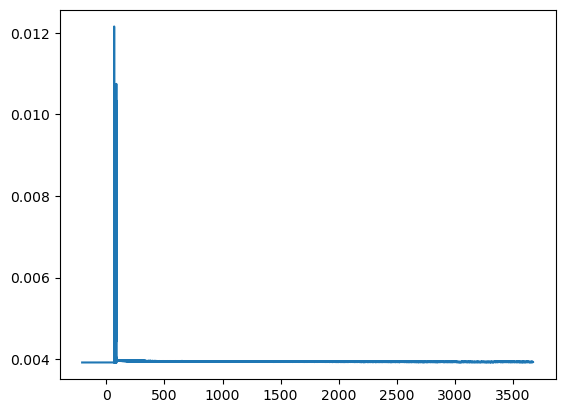

In [20]:
# confirm bad signal by plotting raw photometry data
%matplotlib inline
eid_sus = '16aa7570-578f-4daa-8244-844716fb1320'
phot_signal = load_photometry(eid_sus).values
phot_times = load_photometry(eid_sus).index
plt.plot(phot_times, phot_signal)
# plt.ylim(0, 0.01)
plt.show()

# confirmed all of the above in all_samples[array_idx] are bad sessions
# the question now is whether there are more of these and how to identify them

In [155]:
# for the time beig filter out trials with extremely large values, or extremely poor fit (r^2 < 0.01)
# not a big difference when filtering out the r^2 values

filtered_slopes1 = [s for s, r2 in zip(slopes1, r_squared1) if (-1e4 < s < 1e4) and (r2 >= 0.0)]
print(f'filtered slopes: {filtered_slopes1}')

# check to make sure the 10e3 cutoff is ok (confirmed, just needed to filter out the one that is 2e4, rest is much larger)
large_slopes = [s for s, r2 in zip(slopes1, r_squared1) if (s > 1e4)]
print(f'large slopes: {large_slopes}')

# Perform a one-sample t-test against 0
t_stat, p_two_tailed = stats.ttest_1samp(filtered_slopes1, popmean=0)

# Convert to one-tailed p-value for testing if mean > 0
if t_stat > 0:
    p_one_tailed = p_two_tailed / 2
else:
    p_one_tailed = 1 - (p_two_tailed / 2)

print(f'mean slope: {np.nanmean(filtered_slopes1)}')
print(f"t-statistic: {t_stat:.4f}")
print(f"One-tailed p-value (testing if mean > 0): {p_one_tailed}")

filtered slopes: [np.float64(28.654110900325737), np.float64(-23.635490962567037), np.float64(19.173019856913488), np.float64(-71.90144627125834), np.float64(-56.921502782767654), np.float64(39.242935738052545), np.float64(11.836234623000205), np.float64(65.23582351485146), np.float64(9.716284900884494), np.float64(-7.976466344901406), np.float64(-21.078588038541188), np.float64(45.05350792189844), np.float64(-16.347591024531578), np.float64(-151.8181739715029), np.float64(5.746876829112363), np.float64(37.77188083081451), np.float64(18.484032629631283), np.float64(100.76890224315187), np.float64(-1.172653591132021), np.float64(76.17041802465943), np.float64(76.76349584267965), np.float64(81.55127624350384), np.float64(62.53440122232548), np.float64(-72.75419210055301), np.float64(26.23537947769629), np.float64(72.21173091319606), np.float64(53.653862122006586), np.float64(3.4240461799054094), np.float64(80.65725179073775), np.float64(-22.74245372538368), np.float64(84.99436929388044),

In [160]:
# One-way ANOVA

from scipy.stats import f_oneway

filter_idx = [i for i, s in enumerate(slopes1) if (-1e4 < s < 1e4)]
filtered_responses1 = [r for i, r in enumerate(responses1) if i in filter_idx]
defective_idx = [i for i, s in enumerate(slopes1) if (s < -1e4) or (s > 1e4)]

group1 = [lst[0] for lst in filtered_responses1]
group2 = [lst[1] for lst in filtered_responses1]
group3 = [lst[2] for lst in filtered_responses1]
group4 = [lst[3] for lst in filtered_responses1 if len(lst)>3]
group5 = [lst[4] for lst in filtered_responses1 if len(lst)>4]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(group1, group2, group3, group4, group5)

print(f"F-statistic: {f_stat:.6f}")
print(f"P-value: {p_value:.6f}")


F-statistic: 5.220068
P-value: 0.000366


(array([  1.,   7., 120.,  61.,  11.,   2.,   1.,   0.,   0.,   1.]),
 array([-151.81817397,  -93.80438555,  -35.79059713,   22.22319129,
          80.23697971,  138.25076814,  196.26455656,  254.27834498,
         312.2921334 ,  370.30592182,  428.31971024]),
 <BarContainer object of 10 artists>)

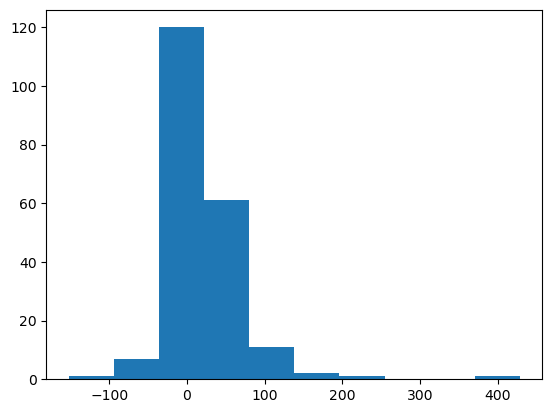

In [157]:
plt.hist(filtered_slopes1, bins=10)

### Adjust response window by reaction time

In [6]:
def reaction_time_with_contrast(trials, events):

    # Define reaction time as the time elapsed between event of interest and stimulus onset
    reaction_time = trials[events] - trials['stimOn_times']

    # define the contrast levels
    contrast_levels = [0, 0.0625, 0.125, 0.25, 1]

    # store result for each
    results = np.zeros(len(contrast_levels))
    idx = 0

    for contrast in contrast_levels:
        trial_idx = trials[(trials['contrastLeft']==contrast) | (trials['contrastRight']==contrast)].index
        result = np.nanmean(reaction_time[trial_idx])
        results[idx] = result
        idx += 1
        # print(f'\nAverage reaction time for contrast level {contrast} is {result:.4f}.')
    
    return results

In [14]:
# define the contrast levels
contrast_levels = [0, 0.0625, 0.125, 0.25, 1]

# store results array
results_array = np.zeros([len(all_samples), len(contrast_levels)])
idx = 0

for trial in all_samples:
    test_df = load_trials(trial)
    results_array[idx, :] = reaction_time_with_contrast(test_df, 'response_times')
    idx += 1

# compute the mean and standard deviation for each contrast level
reaction_time_avg = np.nanmean(results_array, axis=0)
reaction_time_sem = stats.sem(results_array, axis=0, nan_policy='omit')

print(f'average reaction time for each of the contrast levels is {reaction_time_avg}.')
print(f'standard error of the mean in the reaction time for each of the contrast levels is {reaction_time_sem}.')

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_87176/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_87176/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_87176/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_87176/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_87176/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_87176/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx]

average reaction time for each of the contrast levels is [3.57436516 3.10142004 2.30658533 2.02937545 2.13769273].
standard error of the mean in the reaction time for each of the contrast levels is [0.25451266 0.23496504 0.16402364 0.16888061 0.2118745 ].


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_87176/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_87176/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_87176/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])


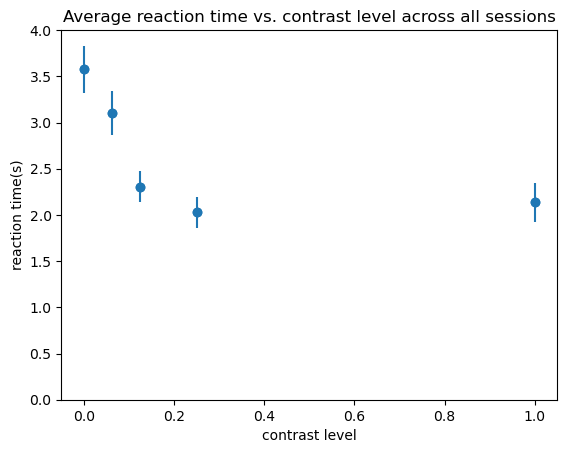

In [15]:
# plot for visualization

fig, ax = plt.subplots()
ax.scatter(contrast_levels, reaction_time_avg)
ax.errorbar(contrast_levels, reaction_time_avg, yerr=reaction_time_sem, fmt='o')
ax.set_xlabel('contrast level')
ax.set_ylabel('reaction time(s)')
ax.set_ylim(0, 4)
ax.set_title('Average reaction time vs. contrast level across all sessions')
plt.show()


### Compare response at feedback times for various contrast levels

In [194]:
# find the eids of sessions that have defective data based on the fitted slopes

valid = []

for eid in all_samples:
    if len(load_trials(eid)['contrastLeft'].unique()) <= 3:
        valid.append(False)
    else:
        valid.append(True)

invalid_idx = [i for i, b in enumerate(valid) if b is False]
invalid_idx # indices for sessions in all_samples where contrast levels are less than or equal to 3, so we skipped
defective_idx # indices for sessions in sessions that were run (so not including those skipped) which have defective data


# Step 1: Construct list of valid indices
valid_idx = [i for i in range(len(all_samples)) if i not in invalid_idx]

# Step 2: Map defective_idx to original all_samples indices
defective_in_all = [valid_idx[i] for i in defective_idx]

# Step 3 (optional): Get their IDs
defective_ids = [all_samples[i] for i in defective_in_all]

defective_ids

# make a new list of all the good samples
better_samples = [eid for eid in all_samples if eid not in defective_ids]
better_samples

['fe2a712b-014b-47e7-b2ac-f85d0571cf44',
 'ba01bf35-8a0d-4ca3-a66e-b3a540b21128',
 'f2a6559d-1e45-4e83-8f65-1295ef50ed4b',
 'c5cdd496-7400-4c0f-b326-55016bce4fcf',
 'fd22820d-a2c2-4c06-b90e-f399344e1c0a',
 '92bf91b5-75db-4e95-8623-fd32c615558f',
 '272c7a84-1f76-4305-a355-4e2149726a9d',
 '48c4f78b-92f7-4ee2-b9c1-5f807197b5e9',
 'e04536b2-b161-478e-af3a-d04bc1ab33ee',
 'df775d7e-3890-4aa3-b7ef-0c6fe6f9abf8',
 '9557f20a-e1ef-44d5-9859-20d1c3854175',
 '26d6c415-23b0-4c49-b73e-b6cf2693df4d',
 '4edc1662-a165-48ef-a332-7172bfca71e7',
 '38c3ebde-c45d-442e-ac61-f42161cfc984',
 'dd549116-68a1-462d-90ef-f4e0ec5c69fc',
 '32eaad6d-fd35-46e9-b7cb-22656d8e3375',
 '68f894bf-2268-4773-aa8d-ac8ab168320e',
 '72e564aa-8416-48fb-a2b9-f9d23e6c7e4b',
 'e9bdcf2b-d0db-42f8-8dfe-3bb82711ff68',
 'a44f72af-755f-4d58-b9bb-c5b345bcd788',
 'f869242e-d1f9-4b7e-a83d-7c794ca6ebbe',
 '4aaa7935-f74d-4797-a26d-598448328795',
 '929662b6-4182-4ee7-8a50-ec788520c9e2',
 '8d9a50bf-8ec7-41f6-a435-de88a6176b06',
 'db7b2ae8-4c68-

In [187]:
def reward_prediction_error(eid, params, events):
    
    session = Photometry(eid)
    contrast_levels = session.contrastLeft.unique()
    contrast_levels = list(contrast_levels[~np.isnan(contrast_levels)])
    contrast_levels.sort()
    # print(contrast_levels)

    # compute the response for each contrast level
    psth_crct, tscale, psth_contrast_crct = session.get_psth(events=events, params=params, contrast=contrast_levels, feedback_type=1.0)
    psth_incrct, tscale, psth_contrast_incrct = session.get_psth(events=events, params=params, contrast=contrast_levels, feedback_type=-1.0)
    time_onset = np.searchsorted(tscale, 0)
    
    idx = 0
    contrast_levels = [0, 0.0625, 0.125, 0.25, 0.5, 1]
    response = np.zeros((len(contrast_levels), 2))

    # sum up 500ms after event depending on contrast levels
    for c_l in contrast_levels:
        if psth_contrast_crct.get(c_l) is None and psth_contrast_incrct.get(c_l) is None:
            response[idx] = None
        else:
            time_period = int(np.floor(0.5 / params.bin_size))
            crct_response_mag = np.nanmean(psth_contrast_crct.get(c_l)[time_onset:time_onset + time_period])
            incrct_response_mag = np.nanmean(psth_contrast_incrct.get(c_l)[time_onset:time_onset + time_period])
            response[idx] = crct_response_mag, incrct_response_mag
            # print(f"response magnitude for contrast level {c_l} is {response_mag}.")
        idx += 1

    # returns response
    return contrast_levels, response

In [195]:
params = Params(pre_time=2, post_time=4, bin_size=0.1, baseline_time=0.2)
cl, res = reward_prediction_error('9d9c2211-3a55-4556-8bf8-b36d2f2deaf1', params=params, events='feedback_times')
cat = [str(level) for level in cl]
response_means = {
    'correct': res[:, 0], 
    'incorrect': res[:, 1]
}

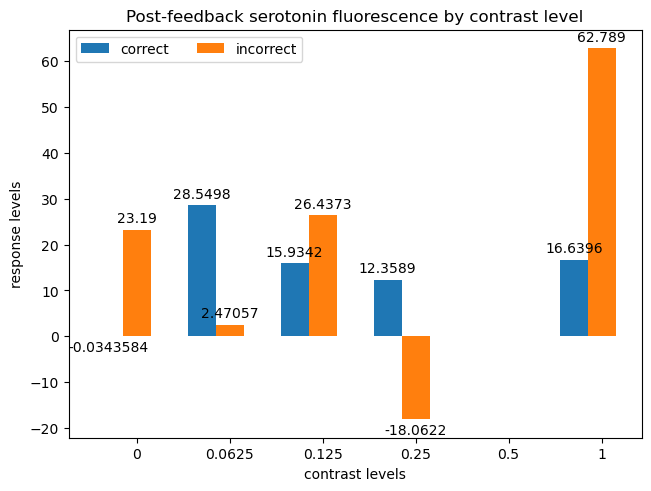

In [196]:
x = np.arange(len(cat))  # the label locations
width = 0.3  # width of bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
for attribute, measurement in response_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# labels, title
ax.set_ylabel('response levels')
ax.set_title("Post-feedback serotonin fluorescence by contrast level")
ax.set_xticks(x + width, cat)
ax.legend(loc='upper left', ncols=2)
# ax.set_ylim(-250, 1800)
ax.set_xlabel('contrast levels')

plt.show()


In [207]:
params = Params(pre_time=2, post_time=4, bin_size=0.1, baseline_time=0.2)
cl, res = reward_prediction_error('20fb5a24-a1b0-4538-803c-cf13eaff2af6', params=params, events='feedback_times')
cat = [str(level) for level in cl]
response_means = {
    'correct': res[:, 0], 
    'incorrect': res[:, 1]
}
response_means

{'correct': array([22.1619137 , 19.48061594,  6.30186949, 24.94904281,         nan,
         8.86086691]),
 'incorrect': array([-20.27369643,  -0.08960396, -10.81714338,  12.69963306,
                 nan,  32.54896747])}

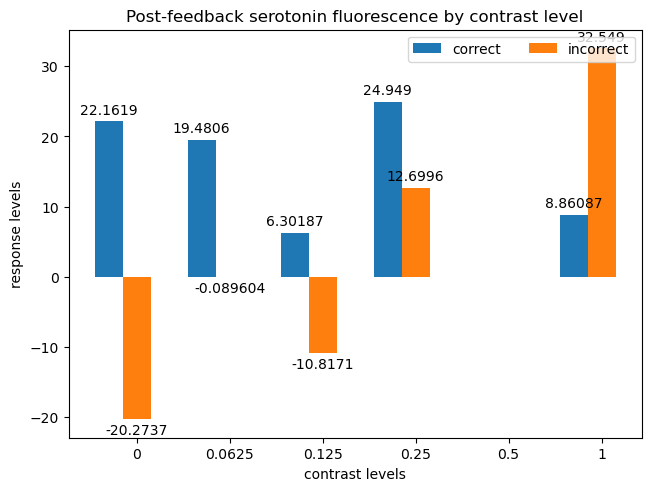

In [198]:
x = np.arange(len(cat))  # the label locations
width = 0.3  # width of bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
for attribute, measurement in response_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# labels, title
ax.set_ylabel('response levels')
ax.set_title("Post-feedback serotonin fluorescence by contrast level")
ax.set_xticks(x + width, cat)
ax.legend(loc='upper right', ncols=2)
# ax.set_ylim(-250, 1800)
ax.set_xlabel('contrast levels')

plt.show()


In [211]:
# filter for bias sessions, need incorrect trials (so proportion_correct < 1)
bias_df = performance_df[(performance_df['stage']=='bias') &
                          (performance_df['proportion_correct']<1)]
bias_df

,subject,session_num,stage,eid,n_trials,n_correct,proportion_correct
24,ZFM-03059,25,bias,b387dd2b-61c4-4e2f-9572-389d40f93fc3,187,185,0.989305
25,ZFM-03059,26,bias,7f3b9633-851a-47e5-b7f8-c92bbbb01cc5,143,140,0.979021
29,ZFM-03059,30,bias,934798fb-006b-4cd4-a546-1b896aa4c212,212,209,0.985849
30,ZFM-03059,31,bias,d6629588-d238-4433-ad46-8ab6feb4cd0a,31,29,0.935484
33,ZFM-03059,34,bias,075a551f-ae82-4b9a-b659-fe94b638b7aa,100,92,0.920000
...,...,...,...,...,...,...,...
575,ZFM-05248,65,bias,65b43acb-afa5-4590-a400-f7f4c79788ab,182,170,0.934066
576,ZFM-05248,66,bias,9c86d1db-cb3f-4bfe-bdd4-450c25b1b779,262,239,0.912214
577,ZFM-05248,67,bias,b46d38e4-cba5-4d2f-b975-93542a452317,113,101,0.893805
578,ZFM-05248,68,bias,f416af34-121d-419c-8d27-4e95f8648012,168,161,0.958333


In [213]:
# need to be available (in metadf) and also filter out defective sessions (in better_samples)
better_samples_bias = bias_df[(bias_df['eid'].isin(metadf['eid'])) & (bias_df['eid'].isin(better_samples))]
better_samples_bias

,subject,session_num,stage,eid,n_trials,n_correct,proportion_correct
24,ZFM-03059,25,bias,b387dd2b-61c4-4e2f-9572-389d40f93fc3,187,185,0.989305
25,ZFM-03059,26,bias,7f3b9633-851a-47e5-b7f8-c92bbbb01cc5,143,140,0.979021
29,ZFM-03059,30,bias,934798fb-006b-4cd4-a546-1b896aa4c212,212,209,0.985849
30,ZFM-03059,31,bias,d6629588-d238-4433-ad46-8ab6feb4cd0a,31,29,0.935484
33,ZFM-03059,34,bias,075a551f-ae82-4b9a-b659-fe94b638b7aa,100,92,0.920000
...,...,...,...,...,...,...,...
575,ZFM-05248,65,bias,65b43acb-afa5-4590-a400-f7f4c79788ab,182,170,0.934066
576,ZFM-05248,66,bias,9c86d1db-cb3f-4bfe-bdd4-450c25b1b779,262,239,0.912214
577,ZFM-05248,67,bias,b46d38e4-cba5-4d2f-b975-93542a452317,113,101,0.893805
578,ZFM-05248,68,bias,f416af34-121d-419c-8d27-4e95f8648012,168,161,0.958333


In [217]:
nsessions = better_samples_bias.shape[0]
params = Params(pre_time=2, post_time=4, bin_size=0.1, baseline_time=0.2)
all_responses = np.zeros((nsessions, 6, 2))
idx = 0

for eid in better_samples_bias['eid']:
    try: 
        cl, res = reward_prediction_error(eid, params=params, events='feedback_times')
        all_responses[idx] = res
        print(f'completed session {idx + 1}/{nsessions}.')
    except Exception as e:
        print(f"Skipping {eid} due to error: {e}")
        continue
    idx += 1

print(np.nanmean(all_responses, axis=0))

completed session 1/87.
completed session 2/87.
completed session 3/87.
completed session 4/87.
completed session 5/87.
completed session 6/87.
completed session 7/87.
completed session 8/87.
completed session 9/87.
completed session 10/87.
completed session 11/87.
completed session 12/87.
completed session 13/87.
completed session 14/87.
completed session 15/87.
completed session 16/87.
completed session 17/87.
completed session 18/87.
completed session 19/87.
completed session 20/87.
completed session 21/87.
completed session 22/87.
completed session 23/87.
completed session 24/87.
completed session 25/87.
completed session 26/87.
completed session 27/87.
completed session 28/87.
completed session 29/87.
completed session 30/87.
completed session 31/87.
completed session 32/87.
completed session 33/87.
completed session 34/87.
completed session 35/87.
completed session 36/87.
completed session 37/87.
completed session 38/87.
completed session 39/87.
completed session 40/87.
completed

/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


completed session 45/87.
completed session 46/87.


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1572329316.py:287: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self._psth_contrast_sem[level] = stats.sem(trials[idx], axis=0, nan_policy='omit')


completed session 47/87.
completed session 48/87.
completed session 49/87.
completed session 50/87.
completed session 51/87.
completed session 52/87.
completed session 53/87.
completed session 54/87.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


completed session 55/87.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


completed session 56/87.
completed session 57/87.
completed session 58/87.
completed session 59/87.
completed session 60/87.
completed session 61/87.
completed session 62/87.
completed session 63/87.
completed session 64/87.
completed session 65/87.
completed session 66/87.
completed session 67/87.
completed session 68/87.
completed session 69/87.
completed session 70/87.
completed session 71/87.
completed session 72/87.
completed session 73/87.
completed session 74/87.
completed session 75/87.
completed session 76/87.
completed session 77/87.
completed session 78/87.
completed session 79/87.
completed session 80/87.
completed session 81/87.
completed session 82/87.
completed session 83/87.
completed session 84/87.
completed session 85/87.
completed session 86/87.
completed session 87/87.
[[22.64991609 18.76933943]
 [22.24850974 17.40598642]
 [23.9329666  27.26996527]
 [23.10843075 15.22013128]
 [        nan         nan]
 [31.78909613 23.25299929]]


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/237923080.py:16: RuntimeWarning: Mean of empty slice
  print(np.nanmean(all_responses, axis=0))


In [236]:
# all_responses = all_responses[:idx]
res_mean = np.nanmean(all_responses, axis=0)
res_sem = stats.sem(all_responses, axis=0)
res_sem

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_55241/1469704762.py:2: RuntimeWarning: Mean of empty slice
  res_mean = np.nanmean(all_responses, axis=0)


array([[ 7.04239289,  6.42760151],
       [ 7.28517586,  6.4701032 ],
       [ 8.02514442, 10.1917986 ],
       [ 7.1660102 ,  7.53971603],
       [        nan,         nan],
       [ 7.99424771, 11.19894346]])

In [241]:
cl = [0, 0.0625, 0.125, 0.25, 0.5, 1]
cat = [str(level) for level in cl]
response_means = {
    'correct': res_mean[:, 0], 
    'incorrect': res_mean[:, 1]
}
response_sem = {
    'correct': res_sem[:, 0], 
    'incorrect': res_sem[:, 1]
}

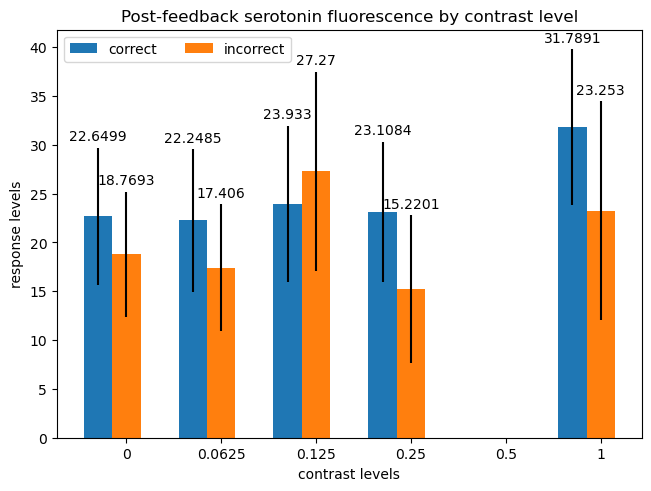

In [ ]:
x = np.arange(len(cat))  # the label locations
width = 0.3  # width of bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
for attribute, measurement in response_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=response_sem[attribute], uplims)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# labels, title
ax.set_ylabel('response levels')
ax.set_title("Post-feedback serotonin fluorescence by contrast level")
ax.set_xticks(x + width, cat)
ax.legend(loc='upper left', ncols=2)
# ax.set_ylim(-250, 1800)
ax.set_xlabel('contrast levels')

plt.show()


## Select low contrast blocks

In [16]:
import numpy as np

def low_contrast_blocks(eid, length=3, crit=[0]):
    '''
    Finds consecutive blocks where the trials are all low contrast
    -------------------
    Parameters:
    eid (str): eid of the session
    length (int): desired number of consecutive low-contrast trials 
    crit (lst): list of contrast levels that constitute "low contrast". 

    '''

    trials = load_trials(eid)
    contrast = trials['contrastLeft'].combine_first(trials['contrastRight'])
    trials['contrast'] = contrast # also store in dataFrame

    # Ensure contrast is a NumPy array
    contrast = np.array(contrast)

    # Make crit a set for fast membership testing
    crit_set = set(crit if isinstance(crit, (list, set, tuple)) else [crit])
    
    # Create boolean mask where contrast is in crit
    is_low = np.isin(contrast, list(crit_set))

    # Find change points in the boolean mask
    diff = np.diff(np.concatenate(([0], is_low.view(np.int8), [0])))
    start_idxs = np.where(diff == 1)[0]   # Run starts
    end_idxs = np.where(diff == -1)[0]    # Run ends

    # Filter runs by length
    valid_runs = [(start, end) for start, end in zip(start_idxs, end_idxs) if end - start >= length]
    
    return valid_runs
    
def longest_low_contrast_block(eid, length=3, crit=[0]):
    '''
    returns the length of the longest low contrast block
    '''
    
    valid_runs = low_contrast_blocks(eid, length, crit)
    max = 0

    for (start, end) in valid_runs: 
        length = end - start
        if length > max:
            max = length
    
    return max

def inter_trial_interval(eid): 
    ''' 
    returns the ITIs for a session
    '''
    trials = load_trials(eid)
    iti = np.diff(trials['goCue_times'])
    return iti

def trial_long(eid):
    '''
    returns the trial_ids that have ITIs greater than 7s. 
    '''
    lst = []
    iti = inter_trial_interval(eid)
    for trial_id, time in enumerate(iti):
        if time >= 7:
            lst.append(trial_id)
    return lst

In [17]:
# eid = metadf['eid'][20]
# print(low_contrast_blocks(eid, crit=[0, 0.0625, 0.125, 0.25]))
# print(longest_low_contrast_block(eid, crit=[0, 0.0625, 0.125, 0.25]))

sessions = []
for eid in metadf['eid']:
    block_length = longest_low_contrast_block(eid, crit=[0, 0.0625, 0.125])
    if block_length > 10:
        sessions.append(eid) 

len(sessions)
# so we have 95 sessions where there's at least one block which are 10 consecutive low 
# (0, 0.0625, 0.125) contrast trials! 

95